---
# **PHASE 1: DATA PREPARATION - Clean, Merge, Exclude Outliers**
---

# 1.1 Preparation and Cleaning - Metrolinx Transit Data

## Overview

### Transit Data File Summary
* GO Train Boardings_2017-2020.xlsx
  * Excel format
  * Rows: 69,094
  * Columns: 26
  * Date Coverage: 2017-03-01 to 2020-02-29 (hourly summaries over a 36 month period)
* GO Access Points.csv
  * CSV format (text, comma separated values)
  * Rows: 977
  * Columns: 18


#### Known Issues:

In order to maintain confidentiality, the boardings values were altered, while maintaining seasonality and trends. Since the values provided do not represent the actual number of passengers boarding the trains, all planned analysis tasks were limited to those requiring only relative passenger behaviour trends (relative changes over time). This condition for release of the data was acceptable, as we were not attempting to analyze profitability or tie back to publicly released statements.

#### Challenges Encountered:

The shape of the data presented an initial challenge. It was originally collected with each passenger boarding timestamped and the station of origin identified. Before it was released to us, the data was summarized into 24 columns, one for each hourly total, and almost 70,000 rows (one row per day for each of 68 stations).



## Import Libraries

In [0]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from pandas.api.types import CategoricalDtype

import numpy as np

from datetime import datetime
import calendar
import holidays

import matplotlib.pyplot as plt
%matplotlib inline

## Read Boarding and Station Data Files into Separate DataFrames; Clean and Reshape

### Data File 1: Load Hourly Train Boardings File; Clean and Reshape to Daily Summary DataFrame

* Read Excel file into Pandas DataFrame
* Replace NaN with zeros
* Apply a correction factor to handle fractional boardings (due to data alterations at source for confidentiality)
* Convert float columns to integer
* Add daily_total column for sum of hourly columns
* Add year_month and week columns to facilitate data aggregation
* Summary information, collected after load:
  * Number of rows: 69,094
  * Number of stations: 68
  * Number of days represented: 1096

#### Load Excel File

[link to Excel file](https://github.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/blob/master/GO%20Transit%20Data/GO%20Train%20Boardings_2017-2020.xlsx?raw=true)

In [139]:
# Load data from Excel file into Pandas DataFrame:
path = 'https://github.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/blob/master/GO%20Transit%20Data/GO%20Train%20Boardings_2017-2020.xlsx?raw=true'

boardings = pd.read_excel(path, 
                          skiprows=1, # skip blank first row
                          usecols=[i for i in range(26)], # no data beyond column 25 (26th column)
                          parse_dates=[1]) # dates in column 1 (2nd column)

# List columns:
boardings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69094 entries, 0 to 69093
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Origin  69094 non-null  object        
 1   Date    69094 non-null  datetime64[ns]
 2   12AM    27381 non-null  float64       
 3   1AM     14521 non-null  float64       
 4   2AM     4294 non-null   float64       
 5   3AM     2535 non-null   float64       
 6   4AM     12866 non-null  float64       
 7   5AM     46922 non-null  float64       
 8   6AM     59113 non-null  float64       
 9   7AM     61954 non-null  float64       
 10  8AM     63100 non-null  float64       
 11  9AM     63702 non-null  float64       
 12  10AM    58368 non-null  float64       
 13  11AM    57093 non-null  float64       
 14  12PM    55188 non-null  float64       
 15  1PM     55418 non-null  float64       
 16  2PM     54763 non-null  float64       
 17  3PM     58323 non-null  float64       
 18  4PM   

In [140]:
print('Number of rows:', len(boardings))
print('Number of stations:', len(list(boardings.Origin.unique())))
print('Number of days represented:', len(list(boardings.Date.unique())))

Number of rows: 69094
Number of stations: 68
Number of days represented: 1096


In [141]:
# Preview first few rows
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,nan,nan,nan,nan,nan,0.27,6.89,5.27,0.00,0.27,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
1,Acton GO,2017-03-02,nan,nan,nan,nan,nan,nan,6.61,3.64,0.00,0.00,nan,0.00,nan,nan,nan,nan,nan,nan,0.27,0.00,nan,nan,nan,nan
2,Acton GO,2017-03-03,nan,nan,nan,nan,nan,0.27,5.40,4.05,0.00,0.00,nan,nan,nan,nan,nan,nan,0.00,0.27,nan,nan,nan,nan,0.00,nan
3,Acton GO,2017-03-04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,Acton GO,2017-03-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan


In [142]:
# View basic stats
# Note fractional boarding counts.  These were introduced by the anonymization algorithm and will need to be adjusted.
boardings.describe()

,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
count,"27,381.00","14,521.00","4,294.00","2,535.00","12,866.00","46,922.00","59,113.00","61,954.00","63,100.00","63,702.00","58,368.00","57,093.00","55,188.00","55,418.00","54,763.00","58,323.00","60,503.00","63,552.00","62,650.00","58,958.00","52,024.00","43,032.00","39,708.00","35,913.00"
mean,3.05,0.79,0.54,0.33,1.48,9.08,37.39,72.27,38.39,8.24,6.73,6.79,7.32,8.06,10.32,24.56,60.28,56.58,19.89,9.38,6.30,6.72,6.74,5.45
std,14.82,3.60,1.74,0.97,3.17,10.52,38.59,78.29,46.00,10.51,9.80,13.38,21.87,29.97,47.77,162.30,465.81,443.64,134.13,55.50,32.15,31.75,34.08,28.46
min,-0.27,-0.41,-0.27,0.00,0.00,0.00,0.00,-1.62,-49.81,-12.29,-2.16,-0.95,-0.41,-0.27,-1.35,-0.81,-0.54,-0.27,-8.91,-0.81,-0.27,-0.41,-0.27,-0.27
25%,0.00,0.00,0.00,0.00,0.00,1.22,6.35,6.75,3.78,0.54,0.68,0.54,0.41,0.41,0.41,0.54,0.68,0.68,0.54,0.27,0.00,0.27,0.27,0.00
50%,0.27,0.00,0.00,0.00,0.27,5.27,23.63,41.44,24.30,4.05,3.38,2.83,2.57,2.29,2.56,2.84,2.70,2.29,1.49,0.95,0.81,1.22,0.95,0.54
75%,0.54,0.27,0.41,0.41,0.95,14.45,55.22,125.69,53.33,12.55,9.18,8.37,7.69,7.16,7.02,8.77,10.80,11.07,6.48,3.64,2.97,2.83,2.03,1.08
max,547.96,122.85,58.05,26.19,24.30,72.09,203.85,404.46,367.60,156.33,115.56,268.11,873.59,"1,342.71","2,432.02","3,805.38","5,229.76","4,945.99","1,673.33",926.51,436.59,464.67,566.87,679.19


In [143]:
# Determine date range:
# !!! Covers all 1096 days (365*3 + leap day) between 2017-03-01 and 2020-02-29.
boardings.Date.describe()

count                   69094
unique                   1096
top       2019-04-02 00:00:00
freq                       68
first     2017-03-01 00:00:00
last      2020-02-29 00:00:00
Name: Date, dtype: object

#### Replace NaN with zeros

In [144]:
# Replace NaNs with zeros:
boardings.fillna(value=0, inplace=True)
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,0.00,0.00,0.00,0.00,0.00,0.27,6.89,5.27,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Acton GO,2017-03-02,0.00,0.00,0.00,0.00,0.00,0.00,6.61,3.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00
2,Acton GO,2017-03-03,0.00,0.00,0.00,0.00,0.00,0.27,5.40,4.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.00
3,Acton GO,2017-03-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Acton GO,2017-03-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Apply a correction factor to handle fractional boardings

In [145]:
# Create a named list of just the hourly columns:
time_column_list = [x for x in boardings.columns if (x[-2:]=='AM') | (x[-2:]=='PM')]
print(len(time_column_list),'time_column_list')

24 time_column_list


In [146]:
# Confirm list has all hourly colums:
boardings[time_column_list].head()

,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,0.00,0.00,0.00,0.00,0.00,0.27,6.89,5.27,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,6.61,3.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.27,5.40,4.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [147]:
# Apply corrective factor to shift all values (manipulated at source for confidentiality) to whole numbers:
boardings[time_column_list]=boardings[time_column_list]/.135
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,0.00,0.00,0.00,0.00,0.00,2.00,51.00,39.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Acton GO,2017-03-02,0.00,0.00,0.00,0.00,0.00,0.00,49.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00
2,Acton GO,2017-03-03,0.00,0.00,0.00,0.00,0.00,2.00,40.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Acton GO,2017-03-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Acton GO,2017-03-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Convert float columns to integer

In [148]:
# Convert float columns to int (boardings can't be fractional):
boardings[time_column_list] = boardings[time_column_list].astype(int)
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,0,0,0,0,0,2,51,39,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acton GO,2017-03-02,0,0,0,0,0,0,48,26,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2,Acton GO,2017-03-03,0,0,0,0,0,2,40,29,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
3,Acton GO,2017-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acton GO,2017-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Plot a 'first look' at the data.  Visualize monthly trends by hour.

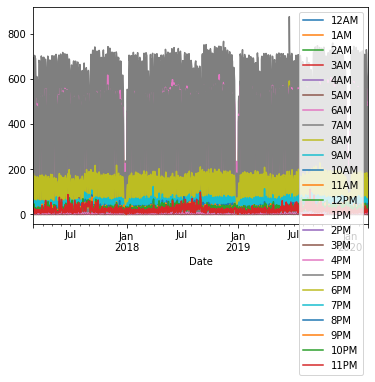

In [149]:
boardings.groupby(['Date']).mean().plot()

#### Add daily_total column for sum of hourly columns and replot:

In [150]:
#Add new column for daily totals:
boardings['daily_total'] = boardings[time_column_list].agg('sum', axis='columns', )
boardings[['Origin','Date','daily_total']].head()

,Origin,Date,daily_total
0,Acton GO,2017-03-01,94
1,Acton GO,2017-03-02,76
2,Acton GO,2017-03-03,73
3,Acton GO,2017-03-04,0
4,Acton GO,2017-03-05,0


In [151]:
first_look_viz_data = boardings[['Date', 'daily_total']].groupby(by='Date').sum()
first_look_viz_data.to_csv("first_look_viz_data.csv", sep=",", index=True)
first_look_viz_data

,daily_total
Date,
2017-03-01,207633
2017-03-02,209194
2017-03-03,190753
2017-03-04,35389
2017-03-05,23126
...,...
2020-02-25,229420
2020-02-26,215063
2020-02-27,210373


![Daily Number of Boardings (Raw Data)](https://raw.githubusercontent.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/master/Images/Daily%20Number%20of%20Boardings%20(Raw).jpg)

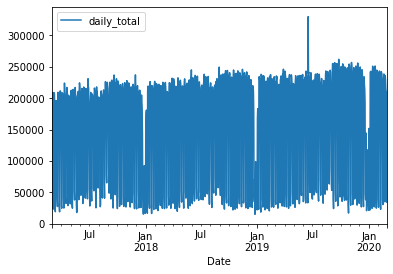

In [152]:
boardings[['Date', 'daily_total']].groupby(by='Date').sum().plot()

In [153]:
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,daily_total
0,Acton GO,2017-03-01,0,0,0,0,0,2,51,39,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94
1,Acton GO,2017-03-02,0,0,0,0,0,0,48,26,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,76
2,Acton GO,2017-03-03,0,0,0,0,0,2,40,29,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,73
3,Acton GO,2017-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acton GO,2017-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Create an aggregated daily_boardings DataFrame for further analysis:

In [154]:
daily_boardings = boardings[['Origin', 'Date', 'daily_total']]
daily_boardings

,Origin,Date,daily_total
0,Acton GO,2017-03-01,94
1,Acton GO,2017-03-02,76
2,Acton GO,2017-03-03,73
3,Acton GO,2017-03-04,0
4,Acton GO,2017-03-05,0
...,...,...,...
69089,York University GO,2020-02-24,275
69090,York University GO,2020-02-25,287
69091,York University GO,2020-02-26,269
69092,York University GO,2020-02-27,264


### Data File 2: Load Bus/Train Access Points File; Clean and Reshape to Basic Train Station Details DataFrame

In [155]:
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/master/GO%20Transit%20Data/GO%20Access%20Points.csv'
access_points = pd.read_csv(path, sep=',')
access_points

,station name,Station Name Trimmed,Clean Stop Name,Line ID,Line Name,Station ID,stop_lat,stop_lon,rail_distance_from_union_miles,Subway,University_College,University_Nm,GO Station_Line,Park and Ride_Carpool,Terminal Station,Shopping Centre,Parent Station,City
0,1| 55|Union Station Rail,Union Station Rail,Union Station,0,Union Station,0,43.65,-79.38,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,Union Station Rail,Toronto
1,1| 1|Agincourt GO Station Rail,Agincourt GO Station Rail,Agincourt GO,6,Stouffville,6002,43.79,-79.28,14.10,0.00,0.00,NaN,6.00,0.00,0.00,0.00,Agincourt GO Station Rail,Scarborough
2,1| 2|Ajax GO Station Rail,Ajax GO Station Rail,Ajax GO,7,Lakeshore East,7007,43.85,-79.04,23.43,0.00,0.00,NaN,7.00,0.00,0.00,0.00,Ajax GO Station Rail,Ajax
3,1| 3|Aldershot GO Station Rail,Aldershot GO Station Rail,Aldershot GO,1,Lakeshore West,1010,43.31,-79.86,34.60,0.00,0.00,NaN,1.00,0.00,0.00,0.00,Aldershot GO Station Rail,Burlington
4,1| 4|Appleby GO Station Rail,Appleby GO Station Rail,Appleby GO,1,Lakeshore West,1008,43.38,-79.76,27.90,0.00,0.00,NaN,1.00,0.00,0.00,0.00,Appleby GO Station Rail,Burlington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,1| 2954|Brampton - BramaleaGOStation At Steeles,Brampton - BramaleaGOStation At Steeles,Bramalea GO Bus,8,GO Bus,80454,43.70,-79.69,nan,0.00,0.00,NaN,3.00,1.00,0.00,0.00,Bramalea GO Station Rail,Bramalea
973,1| 922|Toronto - McCowanRd At ProgressAve,Toronto - McCowanRd At ProgressAve,Toronto - McCowanRd At ProgressAve,8,GO Bus,80899,nan,nan,nan,0.00,0.00,NaN,-1.00,0.00,0.00,0.00,NaN,Toronto
974,1| 2884|Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,8,GO Bus,80900,nan,nan,nan,0.00,0.00,NaN,-1.00,0.00,0.00,0.00,NaN,Oshawa
975,1| 2885|Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,8,GO Bus,80901,nan,nan,nan,0.00,0.00,NaN,-1.00,0.00,0.00,0.00,NaN,Oshawa


Example duplicate stations:

In [156]:
access_points.loc[access_points['Line Name']!='GO Bus','Clean Stop Name'].sort_values()[-20:]

50                            Rouge Hill GO
51                            Rutherford GO
52                           Scarborough GO
60                        St. Catharines GO
53                           Stouffville GO
54                          Streetsville GO
70      Union Pearson Express Bloor Station
69      Union Pearson Express Bloor Station
74    Union Pearson Express Pearson Station
73    Union Pearson Express Pearson Station
67      Union Pearson Express Union Station
68      Union Pearson Express Union Station
72     Union Pearson Express Weston Station
71     Union Pearson Express Weston Station
0                             Union Station
55                            Unionville GO
65                          West Harbour GO
56                                Weston GO
57                                Whitby GO
58                       York University GO
Name: Clean Stop Name, dtype: object

#### Select Required Rows and Columns from Access Points Data to Create 'go_stations' DataFrame

* Filter access points for GO Train stations (exclude GO Bus stops).
* Select required columns: 
 * Clean Stop Name
 * Line ID
 * Line Name

Create a new go_stations dataframe with only required columns and only GO Train stations. (Remove bus stops.)

In [157]:
go_stations = access_points.loc[
                                (access_points['Clean Stop Name'].str.endswith('GO')) |
                                (access_points['Clean Stop Name']=='Union Station') |
                                (access_points['Clean Stop Name']=='Hamilton GO Centre'),
                                'Clean Stop Name':'Line Name'
                                ]
go_stations

,Clean Stop Name,Line ID,Line Name
0,Union Station,0,Union Station
1,Agincourt GO,6,Stouffville
2,Ajax GO,7,Lakeshore East
3,Aldershot GO,1,Lakeshore West
4,Appleby GO,1,Lakeshore West
...,...,...,...
63,Acton GO,3,Kitchener
64,Allandale Waterfront GO,4,Barrie
65,West Harbour GO,1,Lakeshore West
66,Gormley GO,5,Richmond Hill


## Merge Boarding and Station DataFrames; Clean, Reshape and Extend

* Left join daily_boardings['Origin'] = go_stations['Clean Stop Name']
 * Check merge.
* Drop 'Clean Stop Name' column.
* Rename columns.
* Change column order.
* Set Date as the DataFrame index.

### Merge daily boardings data with station details; perform visual check

The daily boarding data was merged with station details to allow analysis by train line (groups of connected stations).

In [158]:
daily_boardings = pd.merge(daily_boardings, go_stations, left_on='Origin', right_on='Clean Stop Name', how='left')
daily_boardings

,Origin,Date,daily_total,Clean Stop Name,Line ID,Line Name
0,Acton GO,2017-03-01,94,Acton GO,3,Kitchener
1,Acton GO,2017-03-02,76,Acton GO,3,Kitchener
2,Acton GO,2017-03-03,73,Acton GO,3,Kitchener
3,Acton GO,2017-03-04,0,Acton GO,3,Kitchener
4,Acton GO,2017-03-05,0,Acton GO,3,Kitchener
...,...,...,...,...,...,...
69089,York University GO,2020-02-24,275,York University GO,4,Barrie
69090,York University GO,2020-02-25,287,York University GO,4,Barrie
69091,York University GO,2020-02-26,269,York University GO,4,Barrie
69092,York University GO,2020-02-27,264,York University GO,4,Barrie


#### Check Merge - Should Be No Nulls in Line ID

In [159]:
daily_boardings[daily_boardings['Line ID'].isnull()]

,Origin,Date,daily_total,Clean Stop Name,Line ID,Line Name


#### Visualize to Check Merge with Stations

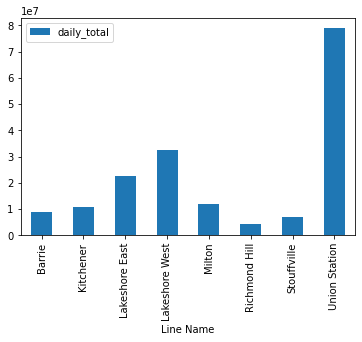

In [160]:
daily_boardings[['Line Name','daily_total']].groupby(by="Line Name").sum().plot(kind='bar');

## Enhance Combined Transit Data: Clean, Reshape and Extend

### Drop 'Clean Stop Name' column.

In [161]:
daily_boardings.drop(columns='Clean Stop Name', inplace=True)
daily_boardings

,Origin,Date,daily_total,Line ID,Line Name
0,Acton GO,2017-03-01,94,3,Kitchener
1,Acton GO,2017-03-02,76,3,Kitchener
2,Acton GO,2017-03-03,73,3,Kitchener
3,Acton GO,2017-03-04,0,3,Kitchener
4,Acton GO,2017-03-05,0,3,Kitchener
...,...,...,...,...,...
69089,York University GO,2020-02-24,275,4,Barrie
69090,York University GO,2020-02-25,287,4,Barrie
69091,York University GO,2020-02-26,269,4,Barrie
69092,York University GO,2020-02-27,264,4,Barrie


### Rename Columns

In [162]:
daily_boardings.rename(columns={'Origin':'station_name', 'Line Name':'line_name', 'Line ID':'line_id'}, inplace=True)
daily_boardings

,station_name,Date,daily_total,line_id,line_name
0,Acton GO,2017-03-01,94,3,Kitchener
1,Acton GO,2017-03-02,76,3,Kitchener
2,Acton GO,2017-03-03,73,3,Kitchener
3,Acton GO,2017-03-04,0,3,Kitchener
4,Acton GO,2017-03-05,0,3,Kitchener
...,...,...,...,...,...
69089,York University GO,2020-02-24,275,4,Barrie
69090,York University GO,2020-02-25,287,4,Barrie
69091,York University GO,2020-02-26,269,4,Barrie
69092,York University GO,2020-02-27,264,4,Barrie


In [163]:
daily_boardings.line_name.value_counts()

Lakeshore West    13989
Kitchener         11633
Barrie            11534
Lakeshore East     9863
Stouffville        9117
Milton             7897
Richmond Hill      3965
Union Station      1096
Name: line_name, dtype: int64

### Change Column Order

In [164]:
daily_boardings = daily_boardings[['Date', 'line_id', 'line_name', 'station_name', 'daily_total']].copy()
daily_boardings

,Date,line_id,line_name,station_name,daily_total
0,2017-03-01,3,Kitchener,Acton GO,94
1,2017-03-02,3,Kitchener,Acton GO,76
2,2017-03-03,3,Kitchener,Acton GO,73
3,2017-03-04,3,Kitchener,Acton GO,0
4,2017-03-05,3,Kitchener,Acton GO,0
...,...,...,...,...,...
69089,2020-02-24,4,Barrie,York University GO,275
69090,2020-02-25,4,Barrie,York University GO,287
69091,2020-02-26,4,Barrie,York University GO,269
69092,2020-02-27,4,Barrie,York University GO,264


### Add Weekday column for further analysis.

* Add a new Weekday column for further analysis.
* Set datatype to category.
* Create custom order (Sunday, Monday, Tuesday...)

In [165]:
daily_boardings['Weekday'] = daily_boardings.apply(
    lambda row: calendar.day_name[datetime.weekday(row['Date'])], axis = 1)

# Set Weekday column to category datatype:
daily_boardings.Weekday = daily_boardings.Weekday.astype('category')

# Apply correct order to weekdays:
weekday_order = ['Sunday','Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday']
weekday_type = CategoricalDtype(categories=weekday_order, ordered=True)
daily_boardings['Weekday'] = daily_boardings['Weekday'].cat.reorder_categories(weekday_order, ordered=True)

daily_boardings

,Date,line_id,line_name,station_name,daily_total,Weekday
0,2017-03-01,3,Kitchener,Acton GO,94,Wednesday
1,2017-03-02,3,Kitchener,Acton GO,76,Thursday
2,2017-03-03,3,Kitchener,Acton GO,73,Friday
3,2017-03-04,3,Kitchener,Acton GO,0,Saturday
4,2017-03-05,3,Kitchener,Acton GO,0,Sunday
...,...,...,...,...,...,...
69089,2020-02-24,4,Barrie,York University GO,275,Monday
69090,2020-02-25,4,Barrie,York University GO,287,Tuesday
69091,2020-02-26,4,Barrie,York University GO,269,Wednesday
69092,2020-02-27,4,Barrie,York University GO,264,Thursday


### Set Date as Index

In [166]:
daily_boardings.set_index('Date', inplace=True)
daily_boardings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69094 entries, 2017-03-01 to 2020-02-28
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   line_id       69094 non-null  int64   
 1   line_name     69094 non-null  object  
 2   station_name  69094 non-null  object  
 3   daily_total   69094 non-null  int64   
 4   Weekday       69094 non-null  category
dtypes: category(1), int64(2), object(2)
memory usage: 2.7+ MB


In [167]:
daily_boardings.head()

,line_id,line_name,station_name,daily_total,Weekday
Date,,,,,
2017-03-01,3,Kitchener,Acton GO,94,Wednesday
2017-03-02,3,Kitchener,Acton GO,76,Thursday
2017-03-03,3,Kitchener,Acton GO,73,Friday
2017-03-04,3,Kitchener,Acton GO,0,Saturday
2017-03-05,3,Kitchener,Acton GO,0,Sunday


### Pivot to create columns for each line

The original GO data contained one row per station and one column per hour.  It was decided the final analysis would require one row per day and one column per station.  New columns were created for total GO ridership per GO line.


In [168]:
go_pivot = daily_boardings.groupby(['line_name','Date'])['daily_total'].sum().to_frame()
go_pivot.reset_index(inplace=True)
go_pivot = go_pivot.pivot(index='Date', columns='line_name', values='daily_total')
go_pivot.fillna(value=0, inplace=True)
go_pivot

line_name,Barrie,Kitchener,Lakeshore East,Lakeshore West,Milton,Richmond Hill,Stouffville,Union Station
Date,,,,,,,,
2017-03-01,"10,022.00","13,585.00","25,273.00","32,909.00","15,599.00","5,639.00","8,804.00","95,802.00"
2017-03-02,"9,932.00","13,331.00","26,120.00","33,884.00","15,653.00","5,665.00","8,736.00","95,873.00"
2017-03-03,"8,905.00","12,235.00","23,801.00","31,473.00","14,092.00","5,129.00","7,918.00","87,200.00"
2017-03-04,928.00,480.00,"7,872.00","11,756.00",208.00,0.00,246.00,"13,899.00"
2017-03-05,803.00,398.00,"4,714.00","8,381.00",169.00,0.00,156.00,"8,505.00"
...,...,...,...,...,...,...,...,...
2020-02-25,"13,650.00","15,097.00","29,727.00","36,973.00","17,192.00","6,865.00","10,485.00","99,431.00"
2020-02-26,"12,596.00","13,557.00","26,690.00","33,732.00","14,331.00","6,215.00","9,749.00","98,193.00"
2020-02-27,"11,349.00","13,074.00","26,818.00","34,180.00","15,281.00","5,522.00","9,151.00","94,998.00"


In [169]:
go_pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2017-03-01 to 2020-02-29
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Barrie          1096 non-null   float64
 1   Kitchener       1096 non-null   float64
 2   Lakeshore East  1096 non-null   float64
 3   Lakeshore West  1096 non-null   float64
 4   Milton          1096 non-null   float64
 5   Richmond Hill   1096 non-null   float64
 6   Stouffville     1096 non-null   float64
 7   Union Station   1096 non-null   float64
dtypes: float64(8)
memory usage: 77.1 KB


In [170]:
print('original daily_boardings shape:',daily_boardings.shape)
print('revised go_pivot shape:',go_pivot.shape)


original daily_boardings shape: (69094, 5)
revised go_pivot shape: (1096, 8)


### Restore Weekday column

In [171]:
#pd.to_datetime(go_pivot.index)
go_pivot.index.strftime('%A')

Index(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       ...
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday'],
      dtype='object', name='Date', length=1096)

In [172]:
go_pivot['Weekday'] = go_pivot.index.strftime('%A')

# Set Weekday column to category datatype:
go_pivot.Weekday = go_pivot.Weekday.astype('category')

# Apply correct order to weekdays:
weekday_order = ['Sunday','Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday']
weekday_type = CategoricalDtype(categories=weekday_order, ordered=True)
go_pivot['Weekday'] = go_pivot['Weekday'].cat.reorder_categories(weekday_order, ordered=True)

go_pivot

line_name,Barrie,Kitchener,Lakeshore East,Lakeshore West,Milton,Richmond Hill,Stouffville,Union Station,Weekday
Date,,,,,,,,,
2017-03-01,"10,022.00","13,585.00","25,273.00","32,909.00","15,599.00","5,639.00","8,804.00","95,802.00",Wednesday
2017-03-02,"9,932.00","13,331.00","26,120.00","33,884.00","15,653.00","5,665.00","8,736.00","95,873.00",Thursday
2017-03-03,"8,905.00","12,235.00","23,801.00","31,473.00","14,092.00","5,129.00","7,918.00","87,200.00",Friday
2017-03-04,928.00,480.00,"7,872.00","11,756.00",208.00,0.00,246.00,"13,899.00",Saturday
2017-03-05,803.00,398.00,"4,714.00","8,381.00",169.00,0.00,156.00,"8,505.00",Sunday
...,...,...,...,...,...,...,...,...,...
2020-02-25,"13,650.00","15,097.00","29,727.00","36,973.00","17,192.00","6,865.00","10,485.00","99,431.00",Tuesday
2020-02-26,"12,596.00","13,557.00","26,690.00","33,732.00","14,331.00","6,215.00","9,749.00","98,193.00",Wednesday
2020-02-27,"11,349.00","13,074.00","26,818.00","34,180.00","15,281.00","5,522.00","9,151.00","94,998.00",Thursday


### Add new Holidays column

A new column for Holidays was created to enable exclusion of statutory holidays as known outliers, due to atypical rider volumes.

In [173]:
holidays_CAN = holidays.Canada(years=[2017,2018,2019,2020], expand=True, observed=True, prov='ON', state=None)
go_pivot["Holiday"] = go_pivot.index.isin(holidays_CAN)
go_pivot

line_name,Barrie,Kitchener,Lakeshore East,Lakeshore West,Milton,Richmond Hill,Stouffville,Union Station,Weekday,Holiday
Date,,,,,,,,,,
2017-03-01,"10,022.00","13,585.00","25,273.00","32,909.00","15,599.00","5,639.00","8,804.00","95,802.00",Wednesday,False
2017-03-02,"9,932.00","13,331.00","26,120.00","33,884.00","15,653.00","5,665.00","8,736.00","95,873.00",Thursday,False
2017-03-03,"8,905.00","12,235.00","23,801.00","31,473.00","14,092.00","5,129.00","7,918.00","87,200.00",Friday,False
2017-03-04,928.00,480.00,"7,872.00","11,756.00",208.00,0.00,246.00,"13,899.00",Saturday,False
2017-03-05,803.00,398.00,"4,714.00","8,381.00",169.00,0.00,156.00,"8,505.00",Sunday,False
...,...,...,...,...,...,...,...,...,...,...
2020-02-25,"13,650.00","15,097.00","29,727.00","36,973.00","17,192.00","6,865.00","10,485.00","99,431.00",Tuesday,False
2020-02-26,"12,596.00","13,557.00","26,690.00","33,732.00","14,331.00","6,215.00","9,749.00","98,193.00",Wednesday,False
2020-02-27,"11,349.00","13,074.00","26,818.00","34,180.00","15,281.00","5,522.00","9,151.00","94,998.00",Thursday,False


In [174]:
holidays_CAN = holidays.Canada(years=[2017,2018,2019,2020], expand=True, observed=True, prov='ON', state=None)
go_pivot["Holiday"] = go_pivot.index.isin(holidays_CAN)
go_pivot

line_name,Barrie,Kitchener,Lakeshore East,Lakeshore West,Milton,Richmond Hill,Stouffville,Union Station,Weekday,Holiday
Date,,,,,,,,,,
2017-03-01,"10,022.00","13,585.00","25,273.00","32,909.00","15,599.00","5,639.00","8,804.00","95,802.00",Wednesday,False
2017-03-02,"9,932.00","13,331.00","26,120.00","33,884.00","15,653.00","5,665.00","8,736.00","95,873.00",Thursday,False
2017-03-03,"8,905.00","12,235.00","23,801.00","31,473.00","14,092.00","5,129.00","7,918.00","87,200.00",Friday,False
2017-03-04,928.00,480.00,"7,872.00","11,756.00",208.00,0.00,246.00,"13,899.00",Saturday,False
2017-03-05,803.00,398.00,"4,714.00","8,381.00",169.00,0.00,156.00,"8,505.00",Sunday,False
...,...,...,...,...,...,...,...,...,...,...
2020-02-25,"13,650.00","15,097.00","29,727.00","36,973.00","17,192.00","6,865.00","10,485.00","99,431.00",Tuesday,False
2020-02-26,"12,596.00","13,557.00","26,690.00","33,732.00","14,331.00","6,215.00","9,749.00","98,193.00",Wednesday,False
2020-02-27,"11,349.00","13,074.00","26,818.00","34,180.00","15,281.00","5,522.00","9,151.00","94,998.00",Thursday,False


# 1.2 Preparation and Cleaning - Weather Data

## Overview

### Weather Data File Summary
* en_climate_daily_ON_6158355_2017_P1D.csv
  * CSV format (text, comma separated values)
  * Rows: 365
  * Columns: 31
* en_climate_daily_ON_6158355_2017_P1D.csv
  * CSV format (text, comma separated values)
  * Rows: 365
  * Columns: 31
* en_climate_daily_ON_6158355_2017_P1D.csv
  * CSV format (text, comma separated values)
  * Rows: 365
  * Columns: 31
* en_climate_daily_ON_6158355_2017_P1D.csv
  * CSV format (text, comma separated values)
  * Rows: 366 (leap year; all values null after 2020-03-24)
  * Columns: 31

##Read Data Files

Weather data was extracted from: https://climate.weather.gc.ca/historical_data/search_historic_data_e.html

Weather data from 2017, 2018, 2019 and 2020 (up to March) was extracted as different datasets, and then concatenated to form one final dataset.


In [175]:
# Set up path variables with explicit file names
path2017 = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/master/Weather%20Data/en_climate_daily_ON_6158355_2017_P1D.csv'
path2018 = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/master/Weather%20Data/en_climate_daily_ON_6158355_2018_P1D.csv'
path2019 = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/master/Weather%20Data/en_climate_daily_ON_6158355_2019_P1D.csv'
path2020 = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/SCS3250-Group-2-Final-Project/master/Weather%20Data/en_climate_daily_ON_6158355_2020_P1D.csv'

# Load each file into a Pandas DataFrame:
weather2017 = pd.read_csv(path2017, parse_dates=[4]) # dates in column 4 (5th column)
weather2018 = pd.read_csv(path2018, parse_dates=[4]) # dates in column 4 (5th column)
weather2019 = pd.read_csv(path2019, parse_dates=[4]) # dates in column 4 (5th column)
weather2020 = pd.read_csv(path2020, parse_dates=[4]) # dates in column 4 (5th column)

# Concatenate all records into a single DataFrame:
weather = pd.concat([weather2017, weather2018, weather2019, weather2020])

weather

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-79.40,43.67,TORONTO CITY,6158355,2017-01-01,2017,1,1,nan,3.10,NaN,-0.50,NaN,1.30,NaN,16.70,NaN,0.00,NaN,nan,M,nan,M,0.00,NaN,3.00,NaN,nan,M,nan,M
1,-79.40,43.67,TORONTO CITY,6158355,2017-01-02,2017,1,2,nan,5.50,NaN,0.70,NaN,3.10,NaN,14.90,NaN,0.00,NaN,nan,M,nan,M,0.00,NaN,3.00,NaN,nan,M,nan,M
2,-79.40,43.67,TORONTO CITY,6158355,2017-01-03,2017,1,3,nan,4.80,NaN,2.40,NaN,3.60,NaN,14.40,NaN,0.00,NaN,nan,M,nan,M,11.30,NaN,1.00,NaN,nan,M,nan,M
3,-79.40,43.67,TORONTO CITY,6158355,2017-01-04,2017,1,4,nan,3.80,NaN,-7.60,NaN,-1.90,NaN,19.90,NaN,0.00,NaN,nan,M,nan,M,0.60,NaN,nan,NaN,nan,M,nan,M
4,-79.40,43.67,TORONTO CITY,6158355,2017-01-05,2017,1,5,nan,-5.30,NaN,-10.30,NaN,-7.80,NaN,25.80,NaN,0.00,NaN,nan,M,nan,M,0.00,NaN,nan,NaN,nan,M,nan,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-79.40,43.67,TORONTO CITY,6158355,2020-12-27,2020,12,27,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN
362,-79.40,43.67,TORONTO CITY,6158355,2020-12-28,2020,12,28,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN
363,-79.40,43.67,TORONTO CITY,6158355,2020-12-29,2020,12,29,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN
364,-79.40,43.67,TORONTO CITY,6158355,2020-12-30,2020,12,30,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN


In [176]:
# List columns:
weather2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude (x)              365 non-null    float64       
 1   Latitude (y)               365 non-null    float64       
 2   Station Name               365 non-null    object        
 3   Climate ID                 365 non-null    int64         
 4   Date/Time                  365 non-null    datetime64[ns]
 5   Year                       365 non-null    int64         
 6   Month                      365 non-null    int64         
 7   Day                        365 non-null    int64         
 8   Data Quality               0 non-null      float64       
 9   Max Temp (°C)              357 non-null    float64       
 10  Max Temp Flag              10 non-null     object        
 11  Min Temp (°C)              361 non-null    float64       
 12  Min Temp

In [177]:
# Display summary statistics:

weather2017.describe()
#weather2018.describe()
#weather2019.describe()
#weather2020.describe()

,Longitude (x),Latitude (y),Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
count,365.00,365.00,365.00,365.00,365.00,365.00,0.00,357.00,361.00,355.00,355.00,355.00,0.00,0.00,350.00,60.00,0.00,0.00
mean,-79.40,43.67,"6,158,355.00","2,017.00",6.53,15.72,nan,13.65,6.14,9.88,9.10,0.98,nan,nan,2.24,4.02,nan,nan
std,0.00,0.00,0.00,0.00,3.45,8.81,nan,10.67,9.42,9.99,8.84,1.91,nan,nan,5.64,4.60,nan,nan
min,-79.40,43.67,"6,158,355.00","2,017.00",1.00,1.00,nan,-13.70,-20.20,-17.00,0.00,0.00,nan,nan,0.00,0.00,nan,nan
25%,-79.40,43.67,"6,158,355.00","2,017.00",4.00,8.00,nan,4.80,0.10,2.75,0.00,0.00,nan,nan,0.00,0.00,nan,nan
50%,-79.40,43.67,"6,158,355.00","2,017.00",7.00,16.00,nan,14.10,5.60,10.30,7.70,0.00,nan,nan,0.00,2.00,nan,nan
75%,-79.40,43.67,"6,158,355.00","2,017.00",10.00,23.00,nan,23.10,14.70,18.60,15.25,0.60,nan,nan,1.40,7.00,nan,nan
max,-79.40,43.67,"6,158,355.00","2,017.00",12.00,31.00,nan,31.70,21.50,26.50,35.00,8.50,nan,nan,52.90,17.00,nan,nan


###Add Year Month Column

The data contains year, month and day. a year-month column was added to make it easier to extract data for a given month and year to use for multiple analyses and summaries later on.

In [178]:
# Add a year-month column for monthly summaries:
weather['year_month'] = weather['Date/Time'].dt.to_period('M')
weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,year_month
0,-79.40,43.67,TORONTO CITY,6158355,2017-01-01,2017,1,1,nan,3.10,NaN,-0.50,NaN,1.30,NaN,16.70,NaN,0.00,NaN,nan,M,nan,M,0.00,NaN,3.00,NaN,nan,M,nan,M,2017-01
1,-79.40,43.67,TORONTO CITY,6158355,2017-01-02,2017,1,2,nan,5.50,NaN,0.70,NaN,3.10,NaN,14.90,NaN,0.00,NaN,nan,M,nan,M,0.00,NaN,3.00,NaN,nan,M,nan,M,2017-01
2,-79.40,43.67,TORONTO CITY,6158355,2017-01-03,2017,1,3,nan,4.80,NaN,2.40,NaN,3.60,NaN,14.40,NaN,0.00,NaN,nan,M,nan,M,11.30,NaN,1.00,NaN,nan,M,nan,M,2017-01
3,-79.40,43.67,TORONTO CITY,6158355,2017-01-04,2017,1,4,nan,3.80,NaN,-7.60,NaN,-1.90,NaN,19.90,NaN,0.00,NaN,nan,M,nan,M,0.60,NaN,nan,NaN,nan,M,nan,M,2017-01
4,-79.40,43.67,TORONTO CITY,6158355,2017-01-05,2017,1,5,nan,-5.30,NaN,-10.30,NaN,-7.80,NaN,25.80,NaN,0.00,NaN,nan,M,nan,M,0.00,NaN,nan,NaN,nan,M,nan,M,2017-01


##Correct/Enhance Data

###Investigate the Flag columns

The dataset contains flags for each attribute column, i.e. each temperature and precipitation column was accompanied by its corresponding flag columns. The unique values for each flag columns were extracted. The description for each value is given below: E = "Estimated"

M = "Missing"

NA = "Not available"

Blank = Value was not observed


In [179]:
weather['Snow on Grnd Flag'].unique()

array([nan, 'T'], dtype=object)

In [180]:
weather['Snow on Grnd Flag'].unique()

array([nan, 'T'], dtype=object)

In [181]:
weather['Total Snow Flag'].unique()

array(['M', nan], dtype=object)

### Find Start of Missing Data (2020-03-25)

In [182]:
weather[(weather['year_month']=='2020-03')&(weather['Mean Temp (°C)'].isnull())].head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,year_month
84,-79.40,43.67,TORONTO CITY,6158355,2020-03-25,2020,3,25,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,2020-03
85,-79.40,43.67,TORONTO CITY,6158355,2020-03-26,2020,3,26,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,2020-03
86,-79.40,43.67,TORONTO CITY,6158355,2020-03-27,2020,3,27,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,2020-03
87,-79.40,43.67,TORONTO CITY,6158355,2020-03-28,2020,3,28,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,2020-03
88,-79.40,43.67,TORONTO CITY,6158355,2020-03-29,2020,3,29,nan,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,2020-03


###Drop irrelevant columns and extract data for specificed range



Since our GO transit data ranged from March 2017 to March 2020, the weather data was curtailed to the same range.

Some data columns were dropped because they were irrelevant to the investigation:

1. All flag columns were dropped since we can extract the actual values from the attribute columns
2. Heating degree-days for a given day are the number of degrees Celsius that the mean temperature is below 18 °C, if temp > 18, this will be 0 - the temperature columns have sufficient info
3. Cool deg days = Cooling degree-days for a given day are the number of degrees Celsius that the mean temperature is above 18 °C, if temp < 18, this will be 0 - the temperature columns have sufficient info
4. Snow on Grnd Flag column contained an additional "T" value which means "trace", which was used to assign a value of "0.5" to the corresponding Snow on Grnd attribute column.



In [0]:
weather = weather[(weather["year_month"] > '2017-02') & (weather["year_month"] < '2020-04')] #extracting March 2017 to March 2020 data
weather = weather.drop(["Longitude (x)",
                        "Latitude (y)", 
                        "Climate ID", 
                        "Data Quality", 
                        "Spd of Max Gust (km/h)", 
                        "Spd of Max Gust Flag", 
                        "Dir of Max Gust (10s deg)", 
                        "Dir of Max Gust Flag", 
                        "Total Rain Flag", 
                        "Total Snow Flag", 
                       "Total Rain (mm)", 
                       "Total Snow (cm)",
                        "Max Temp Flag",
                        "Mean Temp Flag",
                        "Min Temp Flag",
                        "Total Precip Flag",
                        "Heat Deg Days Flag",
                        "Cool Deg Days Flag",
                        "Heat Deg Days (°C)",
                        "Cool Deg Days (°C)",
                        "Station Name"], 
                       axis = 1) 
#unique values for the flags:
# M = missing, E = estimated
#Max Temp Flag = nan, M, E
#Mean Temp Flag = nan, M, E
#Min Temp Flag = nan, M, E
#Total Snow Flag = M, E
#Snow on Grnd Flag = T, nan
#Flags simply mean missing (M), estimated (E), or not filled in (NaN) - we can remove them and just keep temp and prec data
#missing values for max temp, min temp, mean temp, total precipitation

In [184]:
weather.head()

,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Snow on Grnd (cm),Snow on Grnd Flag,year_month
59,2017-03-01,2017,3,1,13.10,-1.90,5.60,18.40,nan,NaN,2017-03
60,2017-03-02,2017,3,2,-1.30,-6.40,-3.90,0.20,0.00,T,2017-03
61,2017-03-03,2017,3,3,-4.30,-8.10,-6.20,0.00,0.00,T,2017-03
62,2017-03-04,2017,3,4,-6.50,-11.90,-9.20,0.20,0.00,T,2017-03
63,2017-03-05,2017,3,5,-0.40,-10.60,-5.50,0.00,0.00,T,2017-03


###Check for missing values and fill them in

There were missing values for the following columns:

1. Max Temp (27 missing)
2. Min Temp (20 missing)
3. Mean Temp (31 missing)
4. Total Precipitation (37 missing)
5. Snow on Grnd (765 missing)

A simple linear interpolation method was used to fill in the missing temperature and precipitation values

On investigating the Snow on Ground column values and correlating with the Snow on Ground flag column (using a monthly average plot), it looks like all the NaN values simply meant 0 snow on the ground on the corresponding days.

For columns where Snow on Ground flag equalled "T" - meaning trace - the corresponding Snow on ground column was changed to "0.5".

After this investigation, the "Snow on Ground Flag" was also dropped from the final dataset


,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Snow on Grnd (cm),year_month
59,2017-03-01,2017,3,1,13.10,-1.90,5.60,18.40,0.00,2017-03
60,2017-03-02,2017,3,2,-1.30,-6.40,-3.90,0.20,0.50,2017-03
61,2017-03-03,2017,3,3,-4.30,-8.10,-6.20,0.00,0.50,2017-03
62,2017-03-04,2017,3,4,-6.50,-11.90,-9.20,0.20,0.50,2017-03
63,2017-03-05,2017,3,5,-0.40,-10.60,-5.50,0.00,0.50,2017-03


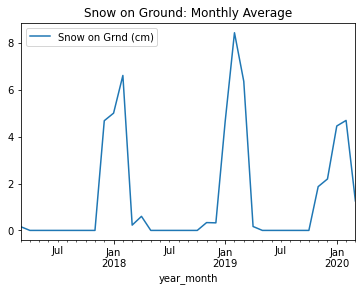

In [185]:
weather['Max Temp (°C)'] = weather['Max Temp (°C)'].interpolate(method='slinear').interpolate(method='linear')
weather['Mean Temp (°C)'] = weather['Mean Temp (°C)'].interpolate(method='slinear').interpolate(method='linear')
weather['Min Temp (°C)'] = weather['Min Temp (°C)'].interpolate(method='slinear').interpolate(method='linear')
weather['Total Precip (mm)'] = weather['Total Precip (mm)'].interpolate(method='slinear').interpolate(method='linear')

weather["Snow on Grnd (cm)"].unique()
weather["Snow on Grnd Flag"].unique()


weather['Snow on Grnd (cm)'] = weather['Snow on Grnd (cm)'].fillna(0) #filling the NaNs with 0's for no snow on ground

weather[weather['year_month']=='2019-04']

# plot snow on ground by month to investigate the trend and missing values for the column
weather[['year_month', 'Snow on Grnd (cm)']].groupby(['year_month']).mean().plot(title='Snow on Ground: Monthly Average')

weather['Snow on Grnd (cm)'] = weather['Snow on Grnd Flag'].apply(lambda x: 0.5 if x == 'T' else x) #for trace snow, changing 0 to 0.5 - number can be changed if needed
weather['Snow on Grnd (cm)'] = weather['Snow on Grnd (cm)'].fillna(0) #filling the NaNs with 0's for no snow on ground

weather = weather.drop(["Snow on Grnd Flag"], 
                       axis = 1) 
weather
weather_data = weather
weather_data.head()

###Addition of monthly mean temperature and precipitation

Because the weather data varies significantly over the year, it was decided to calculate the monthly mean temperature (°C) and the monthly mean precipitation (mm) to understand how the temperature and precipitation varied by month. This data was added to the final dataset.

In [186]:
monthly_mean = weather_data.groupby(by="year_month")['Mean Temp (°C)','Total Precip (mm)'].mean()
monthly_mean = monthly_mean.rename(columns={'Mean Temp (°C)':'Monthly Mean Temp (°C)', 'Total Precip (mm)':'Monthly Mean Precip (mm)'})
weather_data = pd.merge(weather_data, monthly_mean, how='left', left_on='year_month', right_on='year_month')
weather_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Snow on Grnd (cm),year_month,Monthly Mean Temp (°C),Monthly Mean Precip (mm)
0,2017-03-01,2017,3,1,13.10,-1.90,5.60,18.40,0.00,2017-03,-0.25,2.34
1,2017-03-02,2017,3,2,-1.30,-6.40,-3.90,0.20,0.50,2017-03,-0.25,2.34
2,2017-03-03,2017,3,3,-4.30,-8.10,-6.20,0.00,0.50,2017-03,-0.25,2.34
3,2017-03-04,2017,3,4,-6.50,-11.90,-9.20,0.20,0.50,2017-03,-0.25,2.34
4,2017-03-05,2017,3,5,-0.40,-10.60,-5.50,0.00,0.50,2017-03,-0.25,2.34


###Addition of delta mean temperature and precipitation

To understand how the daily temperature/precipitation differed from the calculated monthly mean temperature/precipitation, two new columns were created that represented the difference between the monthly mean temperature/precipitation called Delta Temp (°C) and Delta Precip (mm).

In [187]:
weather_data['Delta Temp (°C)'] = weather_data.apply(lambda row: row["Mean Temp (°C)"] - row["Monthly Mean Temp (°C)"], axis=1)
weather_data['Delta Precip (mm)'] = weather_data.apply(lambda row: row["Total Precip (mm)"] - row["Monthly Mean Precip (mm)"], axis=1)
weather_data

,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Snow on Grnd (cm),year_month,Monthly Mean Temp (°C),Monthly Mean Precip (mm),Delta Temp (°C),Delta Precip (mm)
0,2017-03-01,2017,3,1,13.10,-1.90,5.60,18.40,0.00,2017-03,-0.25,2.34,5.85,16.06
1,2017-03-02,2017,3,2,-1.30,-6.40,-3.90,0.20,0.50,2017-03,-0.25,2.34,-3.65,-2.14
2,2017-03-03,2017,3,3,-4.30,-8.10,-6.20,0.00,0.50,2017-03,-0.25,2.34,-5.95,-2.34
3,2017-03-04,2017,3,4,-6.50,-11.90,-9.20,0.20,0.50,2017-03,-0.25,2.34,-8.95,-2.14
4,2017-03-05,2017,3,5,-0.40,-10.60,-5.50,0.00,0.50,2017-03,-0.25,2.34,-5.25,-2.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,2020-03-27,2020,3,27,8.20,1.40,6.50,0.20,0.00,2020-03,3.35,2.35,3.15,-2.15
1123,2020-03-28,2020,3,28,9.10,4.90,8.20,0.00,0.00,2020-03,3.35,2.35,4.85,-2.35
1124,2020-03-29,2020,3,29,3.80,0.70,2.30,10.60,0.00,2020-03,3.35,2.35,-1.05,8.25
1125,2020-03-30,2020,3,30,8.30,0.40,4.40,10.10,0.00,2020-03,3.35,2.35,1.05,7.75


##Visualizations

###Average values for min, max and mean temperatures by month

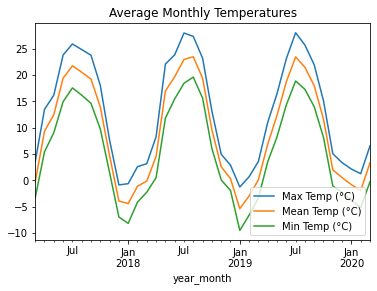

In [188]:
# plot of the average values for min, max and mean temperature by month
weather_data[['year_month', 'Max Temp (°C)', 'Mean Temp (°C)', 'Min Temp (°C)']].groupby('year_month').mean().plot(title='Average Monthly Temperatures')

###Average Total Precipitation by Month

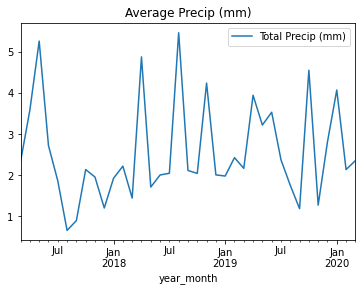

In [189]:
# plot of the average values for total precipitation by month
weather_data[['year_month', 'Total Precip (mm)']].groupby('year_month').mean().plot(title='Average Precip (mm)')

# 1.3 Merge Transit Data and Weather Data; Output to File

## Merge

From there, the weather data and the GO datasets were merged into a final dataset.

In [190]:
go_pivot.head()

line_name,Barrie,Kitchener,Lakeshore East,Lakeshore West,Milton,Richmond Hill,Stouffville,Union Station,Weekday,Holiday
Date,,,,,,,,,,
2017-03-01,"10,022.00","13,585.00","25,273.00","32,909.00","15,599.00","5,639.00","8,804.00","95,802.00",Wednesday,False
2017-03-02,"9,932.00","13,331.00","26,120.00","33,884.00","15,653.00","5,665.00","8,736.00","95,873.00",Thursday,False
2017-03-03,"8,905.00","12,235.00","23,801.00","31,473.00","14,092.00","5,129.00","7,918.00","87,200.00",Friday,False
2017-03-04,928.00,480.00,"7,872.00","11,756.00",208.00,0.00,246.00,"13,899.00",Saturday,False
2017-03-05,803.00,398.00,"4,714.00","8,381.00",169.00,0.00,156.00,"8,505.00",Sunday,False


In [191]:
weather_data.head()

,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Snow on Grnd (cm),year_month,Monthly Mean Temp (°C),Monthly Mean Precip (mm),Delta Temp (°C),Delta Precip (mm)
0,2017-03-01,2017,3,1,13.10,-1.90,5.60,18.40,0.00,2017-03,-0.25,2.34,5.85,16.06
1,2017-03-02,2017,3,2,-1.30,-6.40,-3.90,0.20,0.50,2017-03,-0.25,2.34,-3.65,-2.14
2,2017-03-03,2017,3,3,-4.30,-8.10,-6.20,0.00,0.50,2017-03,-0.25,2.34,-5.95,-2.34
3,2017-03-04,2017,3,4,-6.50,-11.90,-9.20,0.20,0.50,2017-03,-0.25,2.34,-8.95,-2.14
4,2017-03-05,2017,3,5,-0.40,-10.60,-5.50,0.00,0.50,2017-03,-0.25,2.34,-5.25,-2.34


In [192]:
dataset = pd.merge(go_pivot, weather_data, how='left', left_on="Date", right_on="Date/Time")
dataset = dataset.rename(columns={'Date/Time':'Date', 
                                  'Barrie':'Barrie Ridership', 
                                  'Kitchener':'Kitchener Ridership', 
                                  'Lakeshore East':'Lakeshore East Ridership', 
                                  'Lakeshore West':'Lakeshore West Ridership', 
                                  'Milton': 'Milton Ridership', 
                                  'Richmond Hill':'Richmond Hill Ridership', 
                                  'Stouffville':'Stouffville Ridership', 
                                  'Union Station':'Union Station Ridership'})
dataset = dataset[['Date', 'Year', 'Month', 'year_month', 'Day', 'Weekday', 'Holiday',
                   'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Monthly Mean Temp (°C)', 'Delta Temp (°C)', 
                   'Total Precip (mm)', 'Monthly Mean Precip (mm)' , 'Delta Precip (mm)', 'Snow on Grnd (cm)', 
                   'Barrie Ridership', 'Kitchener Ridership', 'Lakeshore East Ridership', 'Lakeshore West Ridership', 
                   'Milton Ridership', 'Richmond Hill Ridership', 'Stouffville Ridership', 'Union Station Ridership']]
dataset

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.10,-1.90,5.60,-0.25,5.85,18.40,2.34,16.06,0.00,"10,022.00","13,585.00","25,273.00","32,909.00","15,599.00","5,639.00","8,804.00","95,802.00"
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.30,-6.40,-3.90,-0.25,-3.65,0.20,2.34,-2.14,0.50,"9,932.00","13,331.00","26,120.00","33,884.00","15,653.00","5,665.00","8,736.00","95,873.00"
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.30,-8.10,-6.20,-0.25,-5.95,0.00,2.34,-2.34,0.50,"8,905.00","12,235.00","23,801.00","31,473.00","14,092.00","5,129.00","7,918.00","87,200.00"
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.50,-11.90,-9.20,-0.25,-8.95,0.20,2.34,-2.14,0.50,928.00,480.00,"7,872.00","11,756.00",208.00,0.00,246.00,"13,899.00"
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.40,-10.60,-5.50,-0.25,-5.25,0.00,2.34,-2.34,0.50,803.00,398.00,"4,714.00","8,381.00",169.00,0.00,156.00,"8,505.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-02-25,2020,2,2020-02,25,Tuesday,False,5.60,1.70,3.70,-1.91,5.61,0.20,2.14,-1.94,0.00,"13,650.00","15,097.00","29,727.00","36,973.00","17,192.00","6,865.00","10,485.00","99,431.00"
1092,2020-02-26,2020,2,2020-02,26,Wednesday,False,4.10,-3.20,0.40,-1.91,2.31,11.80,2.14,9.66,0.00,"12,596.00","13,557.00","26,690.00","33,732.00","14,331.00","6,215.00","9,749.00","98,193.00"
1093,2020-02-27,2020,2,2020-02,27,Thursday,False,-2.70,-5.30,-4.00,-1.91,-2.09,3.10,2.14,0.96,0.00,"11,349.00","13,074.00","26,818.00","34,180.00","15,281.00","5,522.00","9,151.00","94,998.00"
1094,2020-02-28,2020,2,2020-02,28,Friday,False,-2.50,-9.40,-5.90,-1.91,-3.99,1.10,2.14,-1.04,0.00,"11,098.00","13,008.00","27,785.00","34,263.00","14,426.00","5,629.00","8,759.00","95,108.00"


In [193]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1095
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      1096 non-null   datetime64[ns]
 1   Year                      1096 non-null   int64         
 2   Month                     1096 non-null   int64         
 3   year_month                1096 non-null   period[M]     
 4   Day                       1096 non-null   int64         
 5   Weekday                   1096 non-null   category      
 6   Holiday                   1096 non-null   bool          
 7   Max Temp (°C)             1096 non-null   float64       
 8   Min Temp (°C)             1096 non-null   float64       
 9   Mean Temp (°C)            1096 non-null   float64       
 10  Monthly Mean Temp (°C)    1096 non-null   float64       
 11  Delta Temp (°C)           1096 non-null   float64       
 12  Total Precip (mm)   

Datatype of each new column was changed to integer and the Total GO ridership across the entire network was calculated as a new column.


In [194]:
go_ridership = ['Barrie Ridership', 'Kitchener Ridership', 'Lakeshore East Ridership', 'Lakeshore West Ridership', 'Milton Ridership', 'Richmond Hill Ridership', 'Stouffville Ridership', 'Union Station Ridership']
dataset[go_ridership] = dataset[go_ridership].applymap(np.int64)
dataset['Total GO Ridership'] = dataset[go_ridership].sum(axis=1)
dataset[['Date','Total GO Ridership']].head()

,Date,Total GO Ridership
0,2017-03-01,207633
1,2017-03-02,209194
2,2017-03-03,190753
3,2017-03-04,35389
4,2017-03-05,23126


In [0]:
dataset.set_index('Date', inplace=True)

In [196]:
dataset.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership
Date,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.10,-1.90,5.60,-0.25,5.85,18.40,2.34,16.06,0.00,10022,13585,25273,32909,15599,5639,8804,95802,207633
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.30,-6.40,-3.90,-0.25,-3.65,0.20,2.34,-2.14,0.50,9932,13331,26120,33884,15653,5665,8736,95873,209194
2017-03-03,2017,3,2017-03,3,Friday,False,-4.30,-8.10,-6.20,-0.25,-5.95,0.00,2.34,-2.34,0.50,8905,12235,23801,31473,14092,5129,7918,87200,190753
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.50,-11.90,-9.20,-0.25,-8.95,0.20,2.34,-2.14,0.50,928,480,7872,11756,208,0,246,13899,35389
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.40,-10.60,-5.50,-0.25,-5.25,0.00,2.34,-2.34,0.50,803,398,4714,8381,169,0,156,8505,23126


# 1.4 Outlier Analysis

After preprocessing and merging the individual weather, GO station and train boarding datasets, it was necessary to identify and exclude anomalies ("outliers") that could negatively impact machine learning efforts.  Exploratory data analysis was first used to summarize and visualize the consolidated dataset.

The results indicated the presence of multiple subsets of data, due to seasonality, most noticeably related to days of the week but also visible across the calendar year, likely due to recurring annual cycles of employment, education and climate.

Consideration was given to statutory holidays, since business would be closed on those days.  A Holiday column was added to the main dataset to allow those rows to be excluded before analysis and cleaning.

Based on the consistency found within weekday subsets, each one was isolated before excluding records with boarding counts greater than two standard deviations away from the mean.

## Review Consolidated Dataset (Boarding Counts, Station Details, Weather)

The consolidated data in the "dataset" DataFrame was used as input to the outlier detection effort.

In [0]:
# Copying the "dataset" DataFrame to "transit_data" is necessary because the work was split between users.
transit_data = dataset.copy()

In [198]:
transit_data.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership
Date,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.10,-1.90,5.60,-0.25,5.85,18.40,2.34,16.06,0.00,10022,13585,25273,32909,15599,5639,8804,95802,207633
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.30,-6.40,-3.90,-0.25,-3.65,0.20,2.34,-2.14,0.50,9932,13331,26120,33884,15653,5665,8736,95873,209194
2017-03-03,2017,3,2017-03,3,Friday,False,-4.30,-8.10,-6.20,-0.25,-5.95,0.00,2.34,-2.34,0.50,8905,12235,23801,31473,14092,5129,7918,87200,190753
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.50,-11.90,-9.20,-0.25,-8.95,0.20,2.34,-2.14,0.50,928,480,7872,11756,208,0,246,13899,35389
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.40,-10.60,-5.50,-0.25,-5.25,0.00,2.34,-2.34,0.50,803,398,4714,8381,169,0,156,8505,23126


In [199]:
# Sample first few records:
transit_data.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership
Date,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.10,-1.90,5.60,-0.25,5.85,18.40,2.34,16.06,0.00,10022,13585,25273,32909,15599,5639,8804,95802,207633
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.30,-6.40,-3.90,-0.25,-3.65,0.20,2.34,-2.14,0.50,9932,13331,26120,33884,15653,5665,8736,95873,209194
2017-03-03,2017,3,2017-03,3,Friday,False,-4.30,-8.10,-6.20,-0.25,-5.95,0.00,2.34,-2.34,0.50,8905,12235,23801,31473,14092,5129,7918,87200,190753
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.50,-11.90,-9.20,-0.25,-8.95,0.20,2.34,-2.14,0.50,928,480,7872,11756,208,0,246,13899,35389
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.40,-10.60,-5.50,-0.25,-5.25,0.00,2.34,-2.34,0.50,803,398,4714,8381,169,0,156,8505,23126


## Analyze Merged Dataset

### Review Weekday Trends

#### Summary Statistics for Total GO Ridership Column (boarding counts for all stations)

In [200]:
# Check summary statistics of the all-station boarding count column 'Total GO Ridership':
transit_data[['Total GO Ridership']].describe()

,Total GO Ridership
count,"1,096.00"
mean,"161,585.09"
std,"86,259.85"
min,"14,851.00"
25%,"46,647.75"
50%,"209,866.00"
75%,"226,885.50"
max,"330,024.00"


#### Plot Average Monthly Boarding Weekday Trends (All Years Combined) to Expose Any Seasonality

* Compare weekdays (separate lines) as they trend across months - all years combined.
* Due to signficant variation between days, outliers will be calculated for each weekday.
* Note that Saturday boardings peak in August while Monday boardings show the reverse.
* After excluding statutory holidays and outliers, trends should be reassessed. 

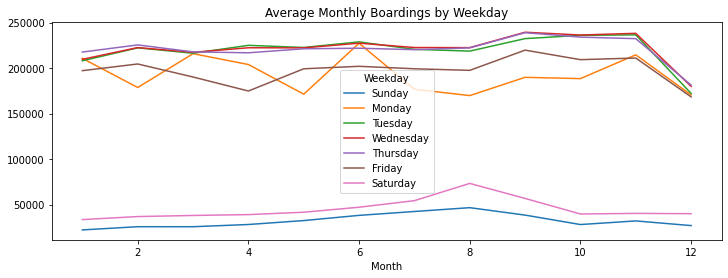

In [201]:
transit_data.pivot_table(values='Total GO Ridership', 
                         index='Month',
                         columns='Weekday', 
                         aggfunc='mean').plot(figsize=(12,4), title='Average Monthly Boardings by Weekday');

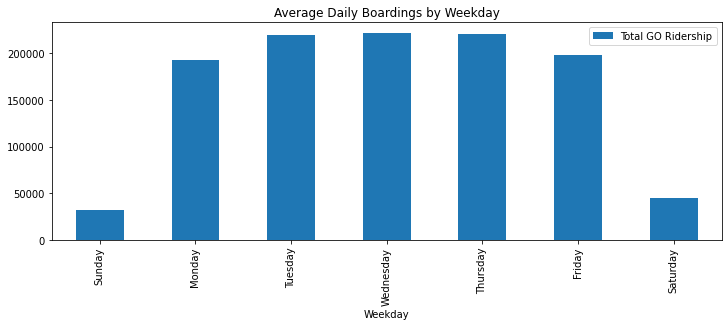

In [202]:
transit_data.pivot_table(values='Total GO Ridership', index='Weekday',
                                aggfunc='mean').plot(kind='bar',figsize=(12,4), title='Average Daily Boardings by Weekday');

#### Plot Total Daily Boardings for High-Level Overview Before Any Data Exclusion

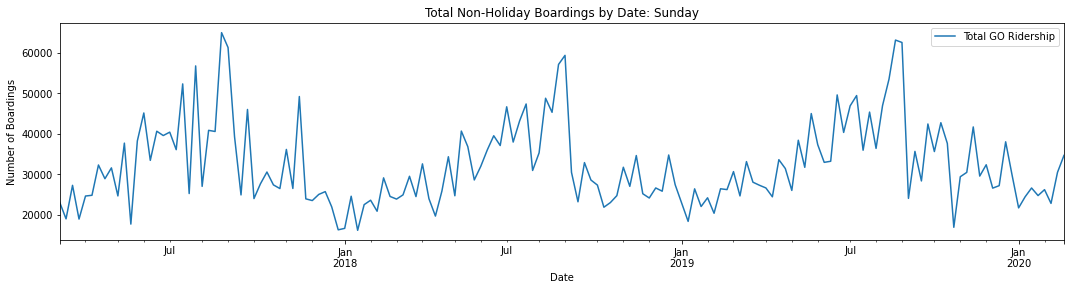

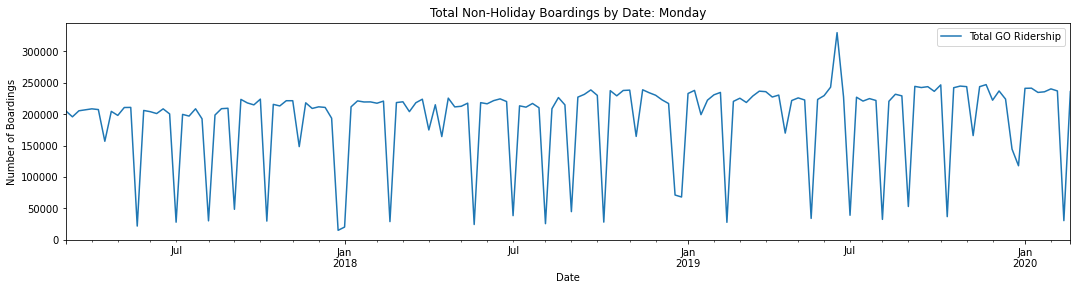

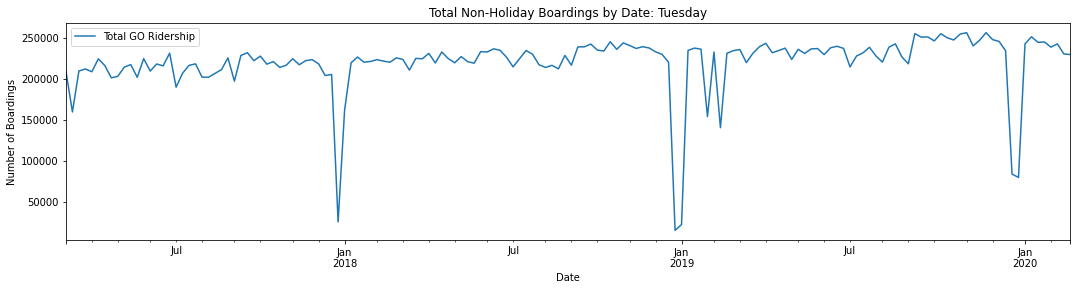

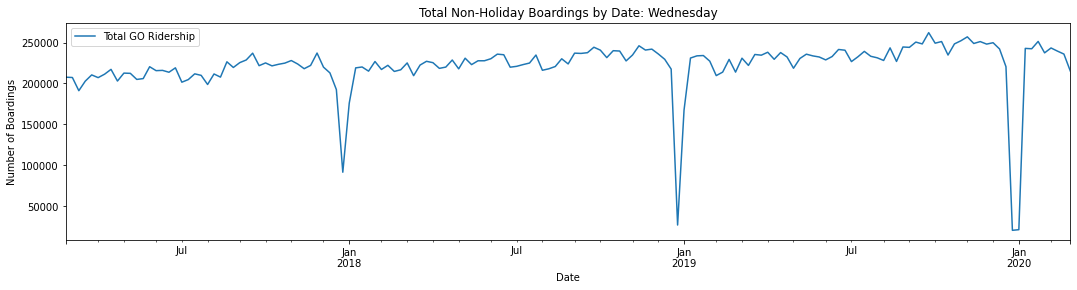

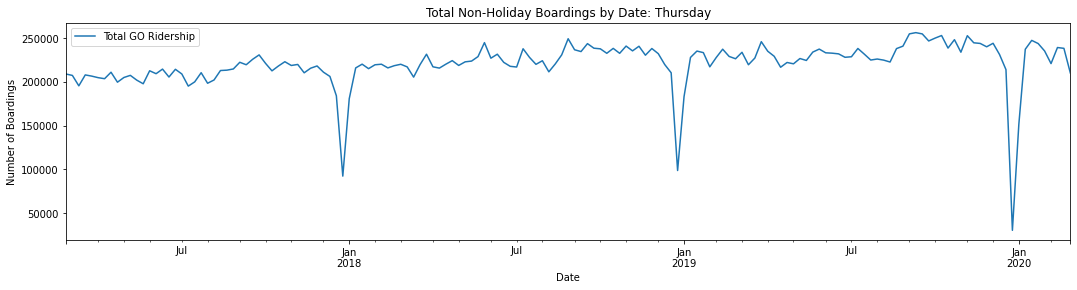

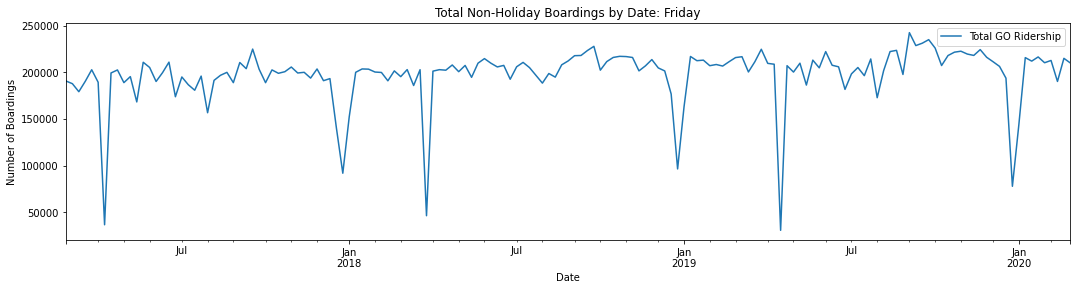

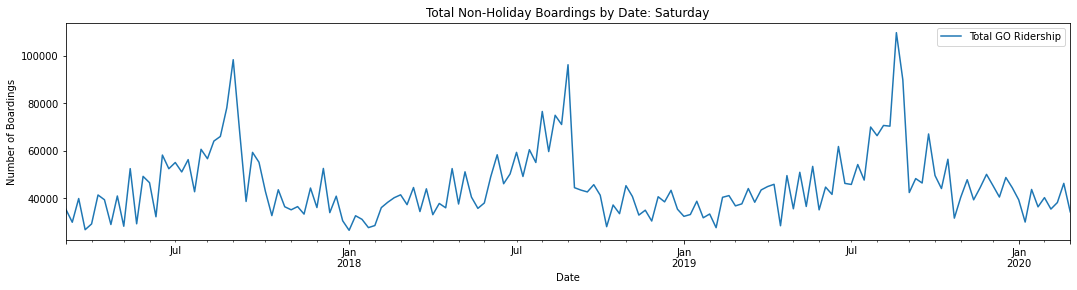

In [203]:
weekdays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
for day in weekdays:
  transit_data.loc[(transit_data.Weekday==day)].plot(y='Total GO Ridership', figsize=(18,4))
  plt.xlabel('Date')
  plt.ylabel('Number of Boardings')
  plt.title('Total Non-Holiday Boardings by Date: '+day)

### Review Impact of Statutory Holidays Exclusion

Plotting data with all dates reveals unusually high and low data points.  Some align with statutory holidays and vacation periods (late December).  Others will need to be identified using statistical methods.

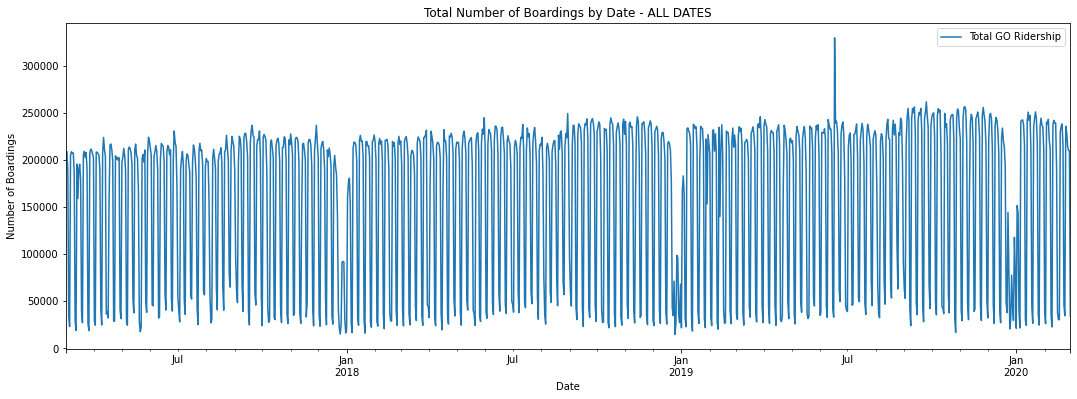

In [204]:
# Plot all data:
transit_data.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Date')
plt.ylabel('Number of Boardings')
plt.title('Total Number of Boardings by Date - ALL DATES');

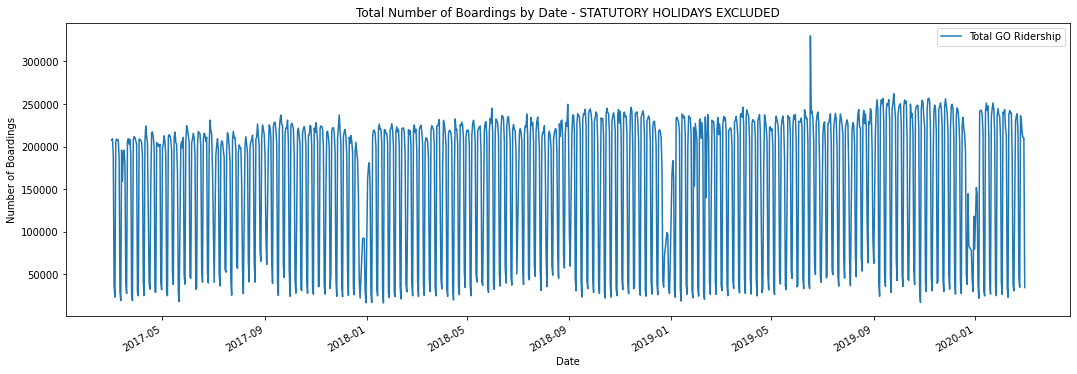

In [205]:
# Plotting without statutory holidays removes some anomalies:
transit_data.loc[-transit_data.Holiday].plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Date')
plt.ylabel('Number of Boardings')
plt.title('Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

### Review Impact of Late December Vacation Periods Exclusion

#### 2017

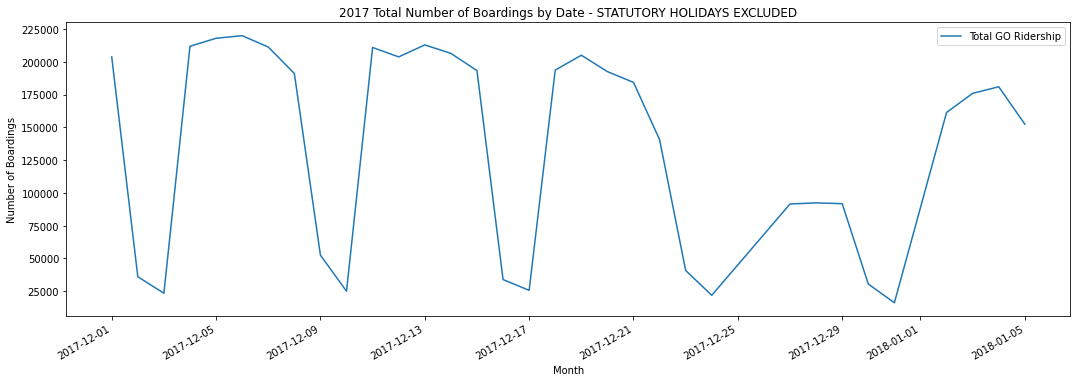

In [206]:
# Plot 2019 end of year vacation period without statutory holidays:
df=transit_data[-transit_data.Holiday]
df = df.loc['2017-12-01':'2018-01-05']

df.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('2017 Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

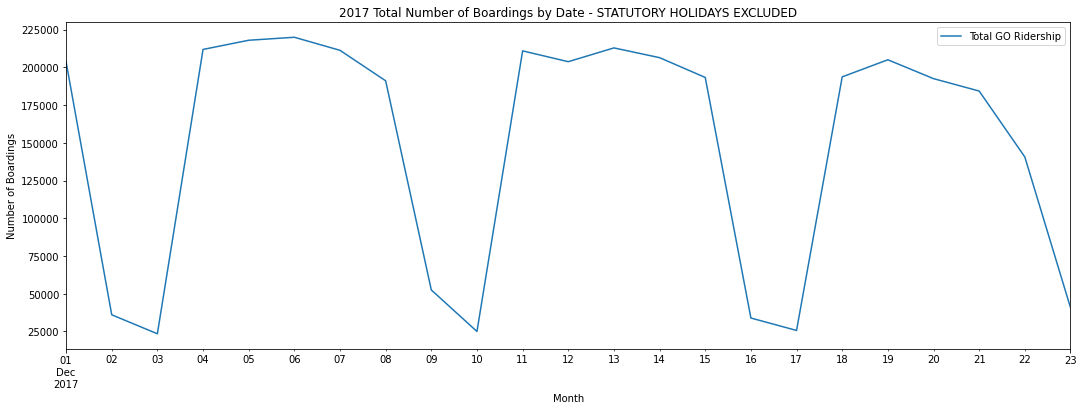

In [207]:
# Plot without holidays or days beyond 2017-12-23 shows improved consistency:
df=transit_data[-transit_data.Holiday]
df = df.loc['2017-12-01':'2018-01-05']

df=df.drop(df.loc['2017-12-24':'2018-01-05'].index)

df.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('2017 Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

#### 2018

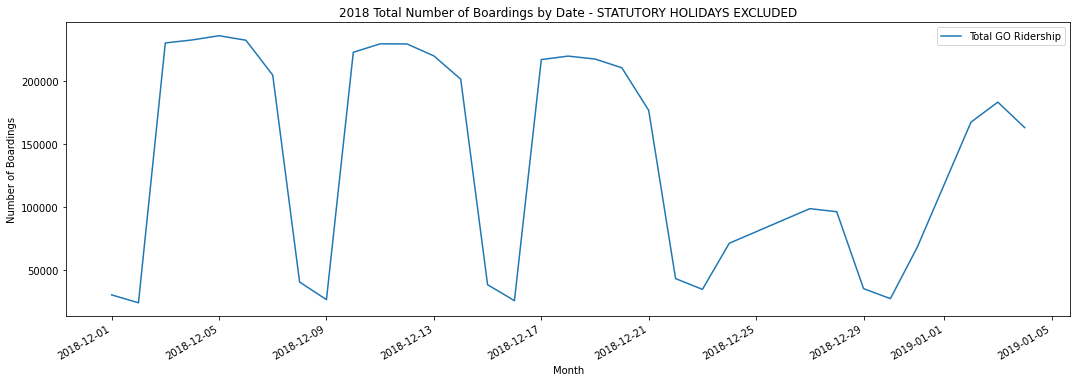

In [208]:
# Plot 2018 end of year vacation period without statutory holidays:
df=transit_data[-transit_data.Holiday]
df = df.loc['2018-12-01':'2019-01-04']

df.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('2018 Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

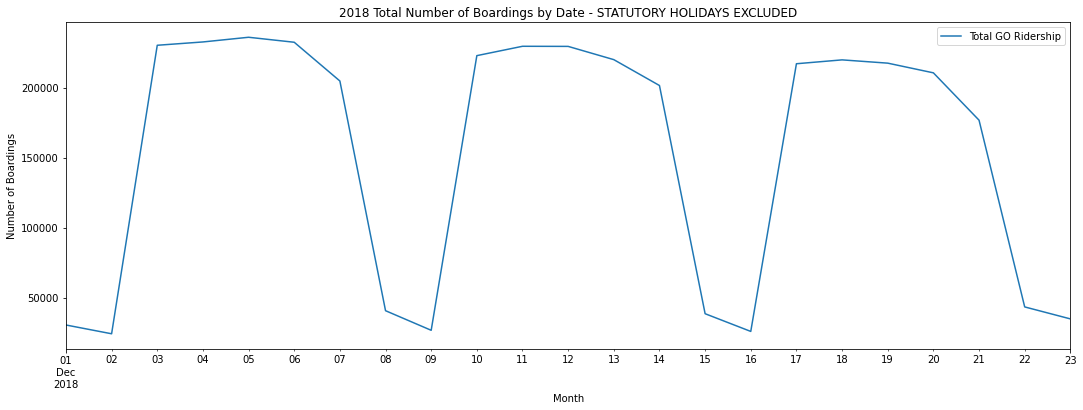

In [209]:
# Plot without holidays or days beyond 2018-12-23 shows improved consistency:
df=transit_data[-transit_data.Holiday]
df = df.loc['2018-12-01':'2019-01-04']

df=df.drop(df.loc['2018-12-24':'2019-01-04'].index)

df.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('2018 Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

#### 2019

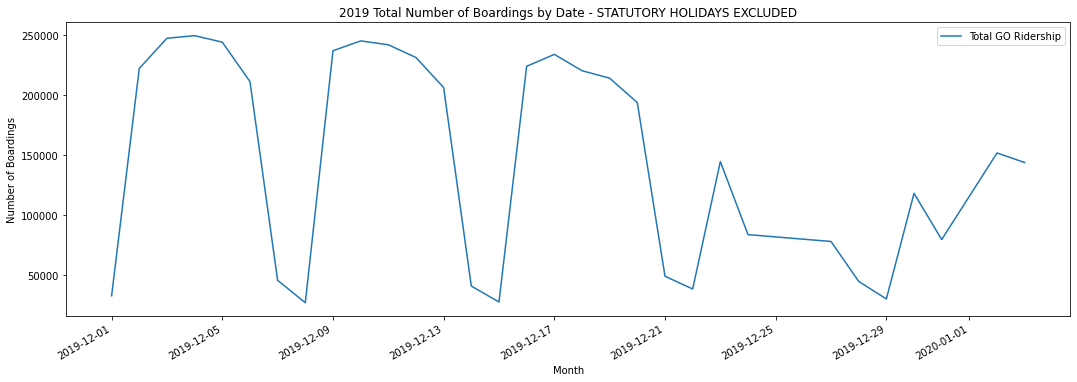

In [210]:
# Plot 2019 end of year vacation period without statutory holidays:
df=transit_data[-transit_data.Holiday]
df = df.loc['2019-12-01':'2020-01-03']

df.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('2019 Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

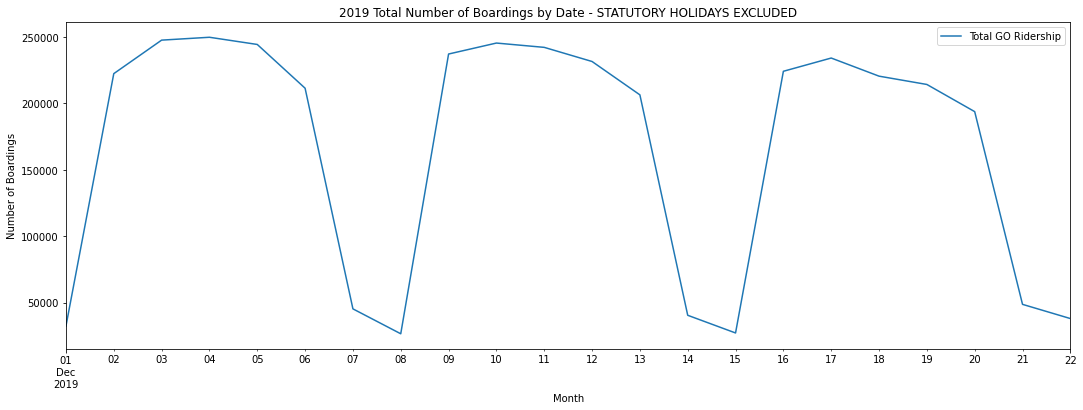

In [211]:
# Plot without holidays or days beyond 2019-12-22 shows improved consistency:
df=transit_data[-transit_data.Holiday]
df = df.loc['2019-12-01':'2020-01-03']

df=df.drop(df.loc['2019-12-23':'2020-01-03'].index)

df.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('2019 Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

## Enhance

### Flag Late December Vacation Periods as Outliers

In [212]:
transit_data['Outlier']=False
transit_data.loc['2017-12-24':'2018-01-05','Outlier']=True
transit_data.loc['2018-12-24':'2019-01-04','Outlier']=True
transit_data.loc['2019-12-23':'2020-01-03','Outlier']=True
print('Days Removed:',len(transit_data[transit_data['Outlier']]))

Days Removed: 37


### Exclude Holidays and Vacations and Replot

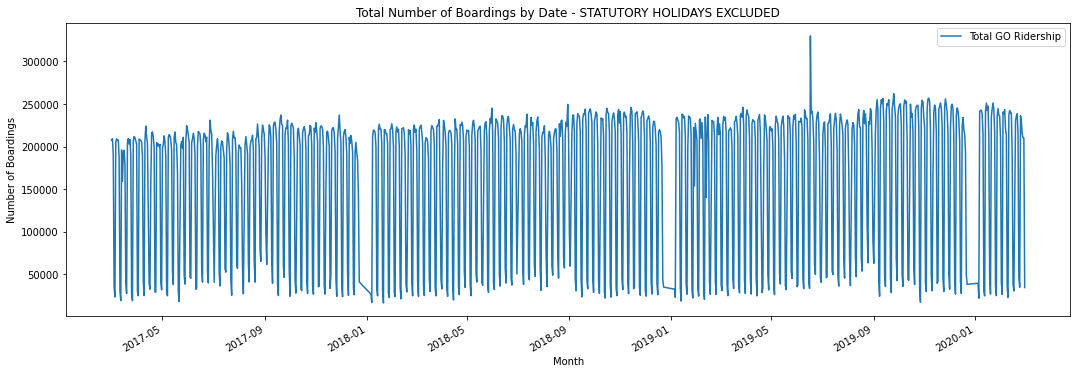

In [213]:
transit_data.loc[(-transit_data.Holiday)&(-transit_data['Outlier'])].plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Month')
plt.ylabel('Number of Boardings')
plt.title('Total Number of Boardings by Date - STATUTORY HOLIDAYS EXCLUDED');

### Plot Each Weekday

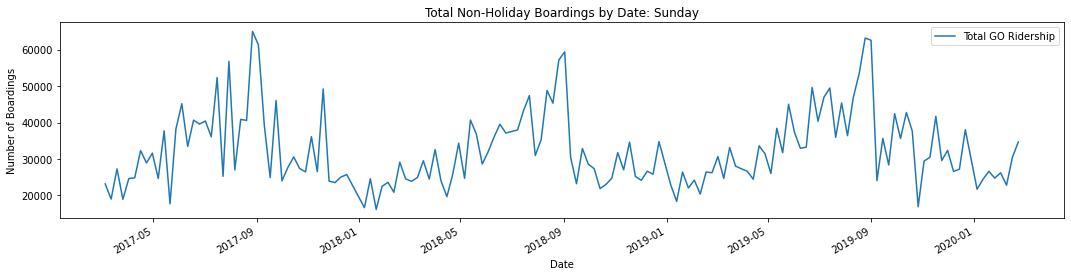

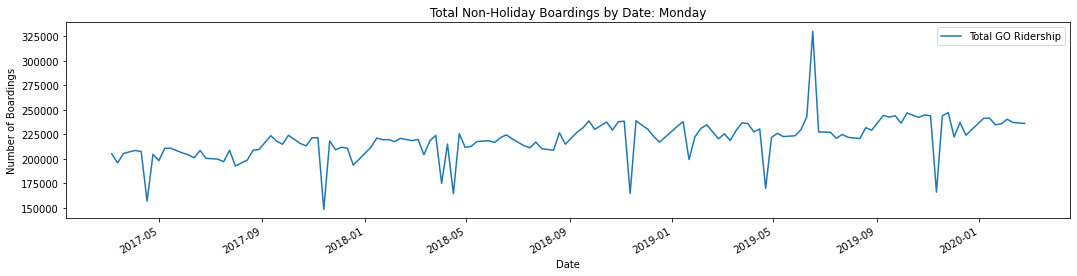

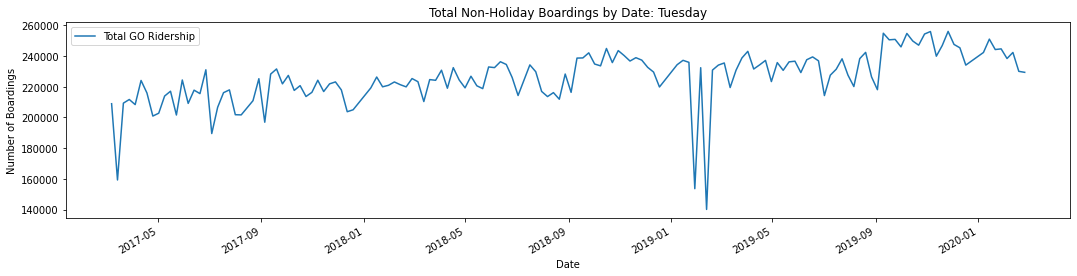

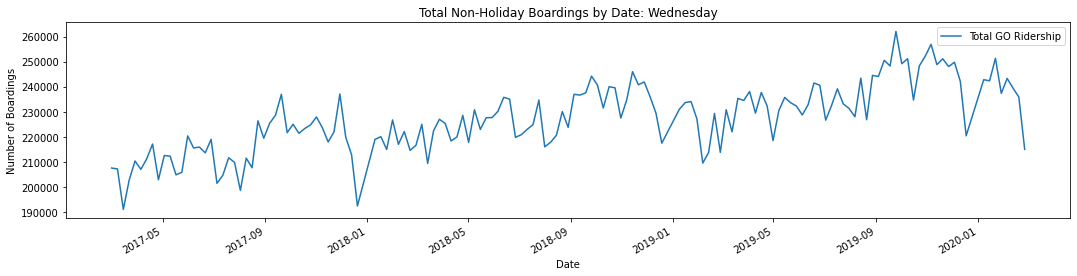

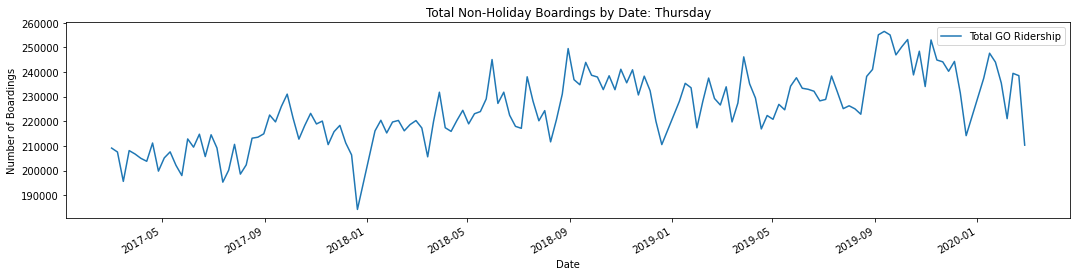

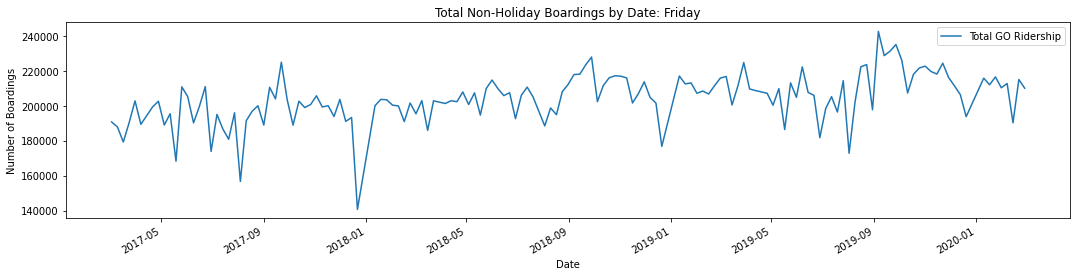

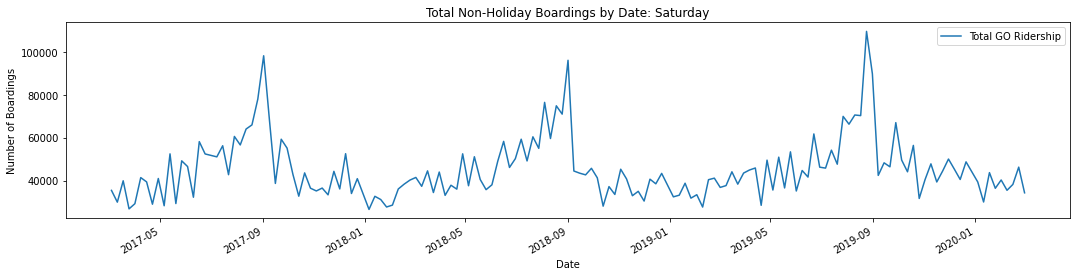

In [214]:
weekdays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
for day in weekdays:
  transit_data.loc[(-transit_data.Holiday)&
                   (-transit_data['Outlier'])&
                   (transit_data.Weekday==day)].plot(y='Total GO Ridership', figsize=(18,4))
  plt.xlabel('Date')
  plt.ylabel('Number of Boardings')
  plt.title('Total Non-Holiday Boardings by Date: '+day)

### Add Weekday-Specific Means and Outlier Boundaries (Two Standard Deviations Above and Below)

In [215]:
transit_data['Overall Mean']=np.NaN
transit_data['2SD_above']=np.NaN
transit_data['2SD_below']=np.NaN
weekdays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
for day in weekdays:
  filter = (-transit_data.Holiday)&(-transit_data['Outlier'])&(transit_data.Weekday==day)
  transit_data.loc[filter,'Overall Mean']=transit_data.loc[filter,'Total GO Ridership'].mean()
  transit_data.loc[filter,'2SD_above']=transit_data.loc[filter,'Total GO Ridership'].mean() + 2*transit_data.loc[filter,'Total GO Ridership'].std()
  transit_data.loc[filter,'2SD_below']=transit_data.loc[filter,'Total GO Ridership'].mean() - 2*transit_data.loc[filter,'Total GO Ridership'].std()
  print(day, len(transit_data.loc[filter]))
transit_data.iloc[[0,50,150]]

Sunday 151
Monday 132
Tuesday 150
Wednesday 151
Thursday 151
Friday 148
Saturday 153


,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.10,-1.90,5.60,-0.25,5.85,18.40,2.34,16.06,0.00,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,"227,296.50","254,365.81","200,227.20"
2017-04-20,2017,4,2017-04,20,Thursday,False,10.00,4.60,7.30,9.34,-2.04,23.30,3.59,19.71,0.00,9793,13559,26090,34896,15628,5592,8475,97212,211245,False,"224,966.62","253,295.70","196,637.54"
2017-07-29,2017,7,2017-07,29,Saturday,False,26.80,16.50,21.70,21.77,-0.07,0.00,1.86,-1.86,0.00,2063,889,11372,23310,419,0,522,22008,60583,False,"45,352.33","73,886.66","16,818.01"


### Plot Each Weekday to Highlight Outliers

Weekday
Sunday       AxesSubplot(0.125,0.2;0.775x0.68)
Monday       AxesSubplot(0.125,0.2;0.775x0.68)
Tuesday      AxesSubplot(0.125,0.2;0.775x0.68)
Wednesday    AxesSubplot(0.125,0.2;0.775x0.68)
Thursday     AxesSubplot(0.125,0.2;0.775x0.68)
Friday       AxesSubplot(0.125,0.2;0.775x0.68)
Saturday     AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

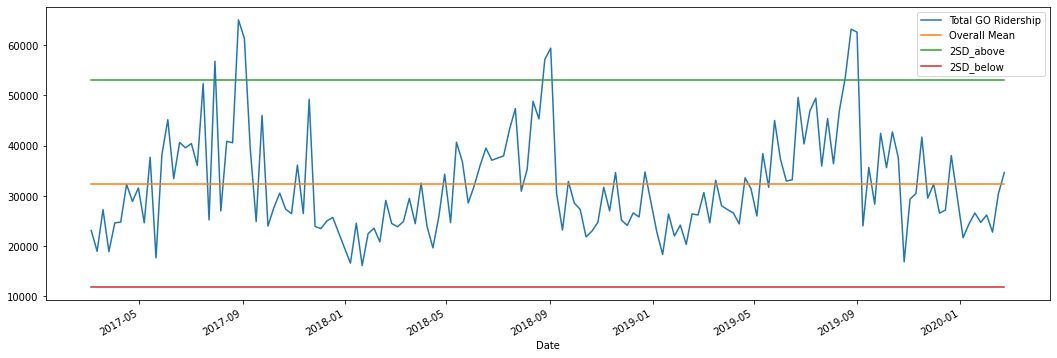

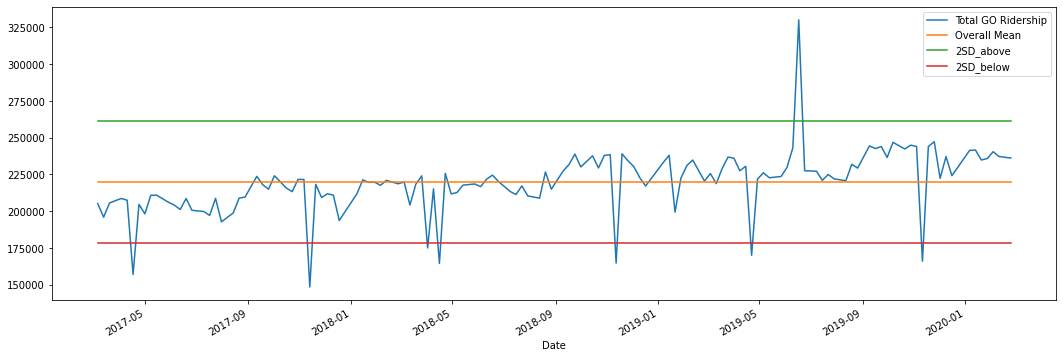

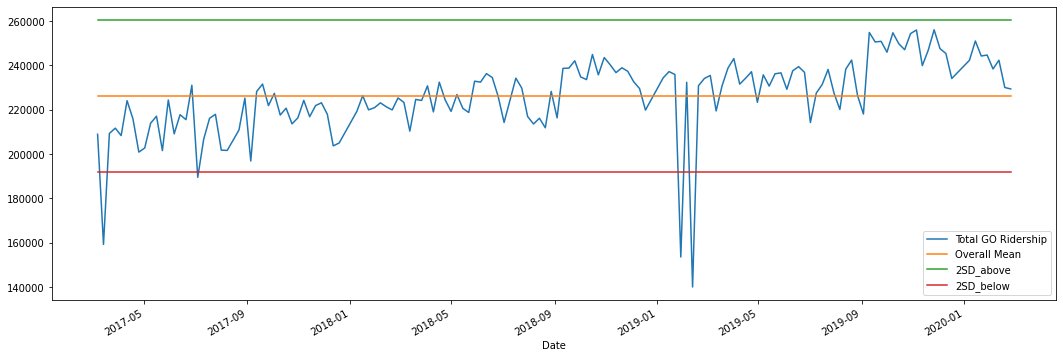

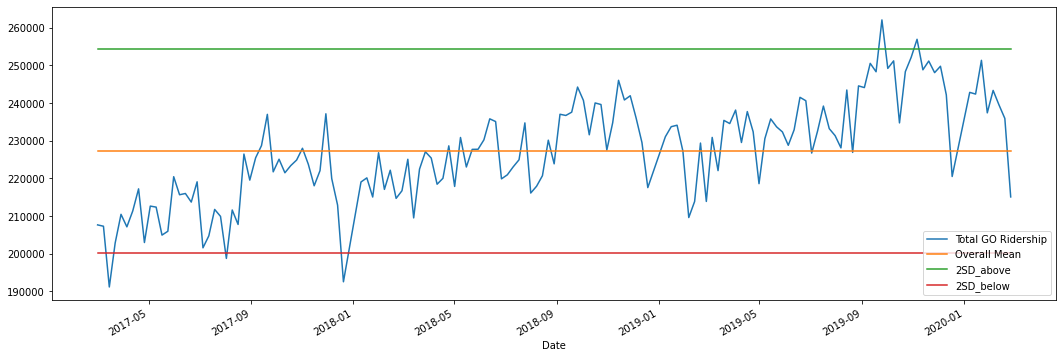

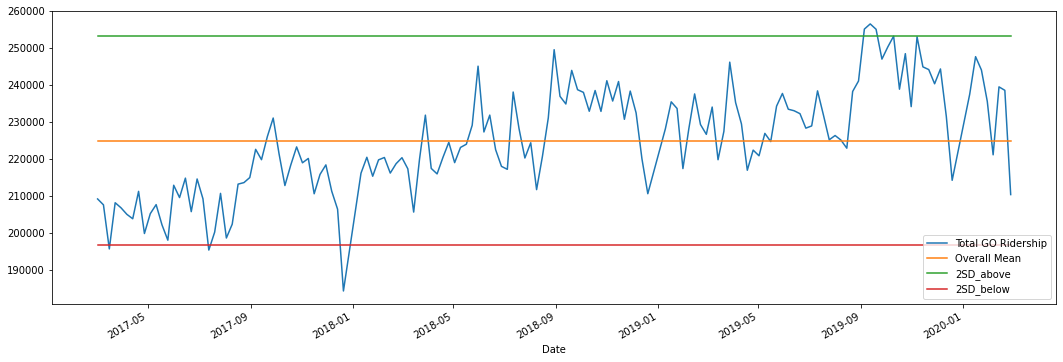

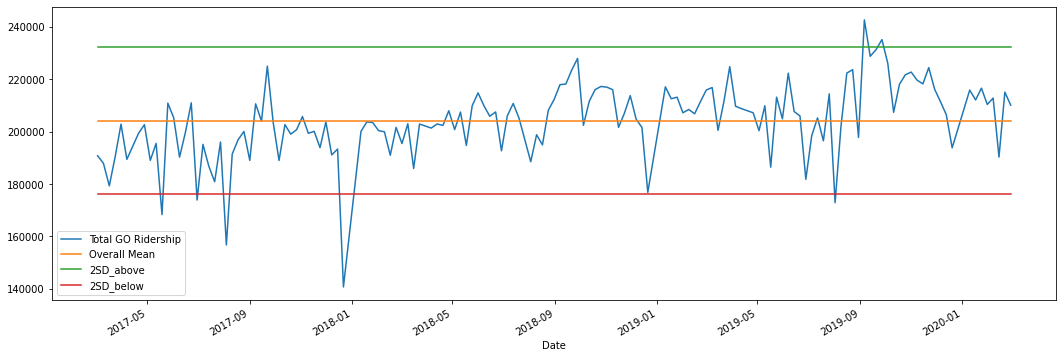

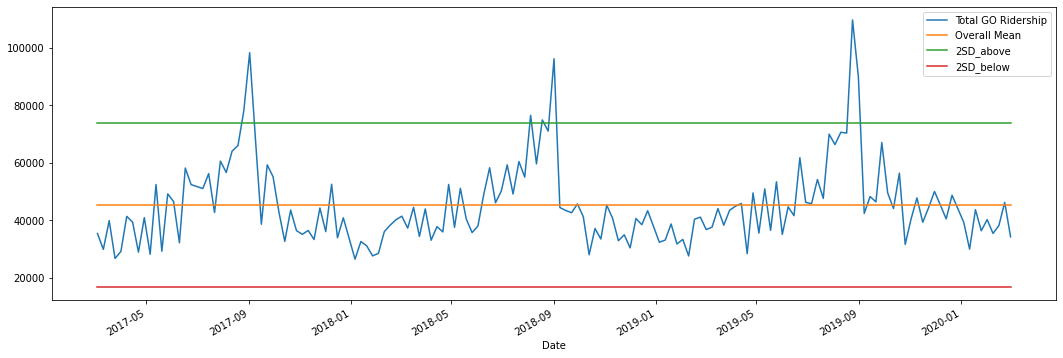

In [216]:
columns = ['Total GO Ridership', 'Overall Mean','2SD_above','2SD_below','Weekday','Holiday']
filter = (-transit_data.Holiday)&(-transit_data['Outlier'])
#df_new.groupby(by='Weekday').plot(figsize=(18,6))
transit_data.loc[filter,columns].groupby(by='Weekday').plot(figsize=(18,6))

### Flag Outliers; Filter Out; Replot to Show Improved Data Quality

In [0]:
#transit_data.loc[(transit_data['Total GO Ridership']>transit_data['2SD_above'])]
filter = (transit_data['Total GO Ridership']>transit_data['2SD_above']) | (transit_data['Total GO Ridership']<transit_data['2SD_below'])
transit_data.loc[filter,'Outlier']=True

In [0]:
# Export for visualization in Tableau
transit_data.to_csv("outlier_analysis.csv", sep=",", index=True)

Weekday
Sunday       AxesSubplot(0.125,0.2;0.775x0.68)
Monday       AxesSubplot(0.125,0.2;0.775x0.68)
Tuesday      AxesSubplot(0.125,0.2;0.775x0.68)
Wednesday    AxesSubplot(0.125,0.2;0.775x0.68)
Thursday     AxesSubplot(0.125,0.2;0.775x0.68)
Friday       AxesSubplot(0.125,0.2;0.775x0.68)
Saturday     AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

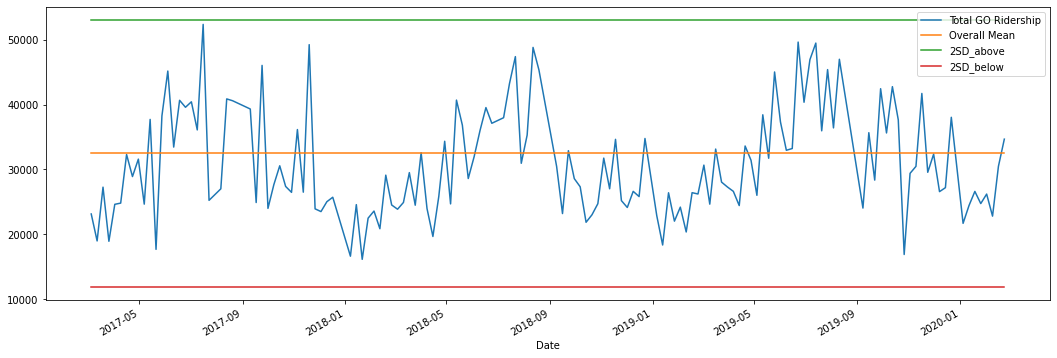

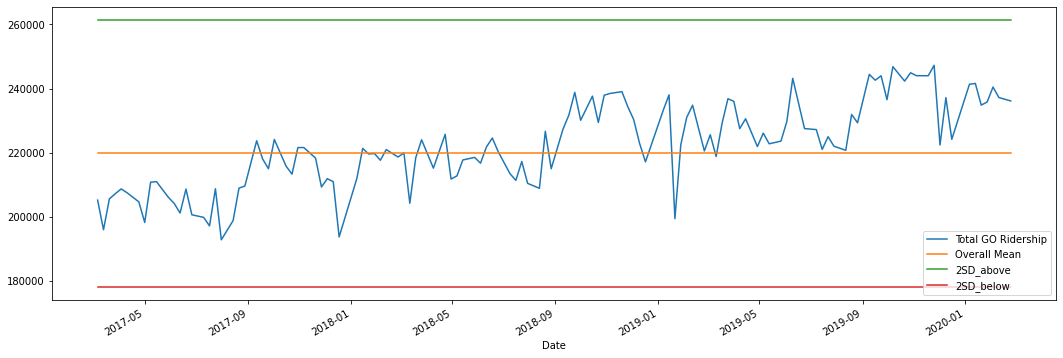

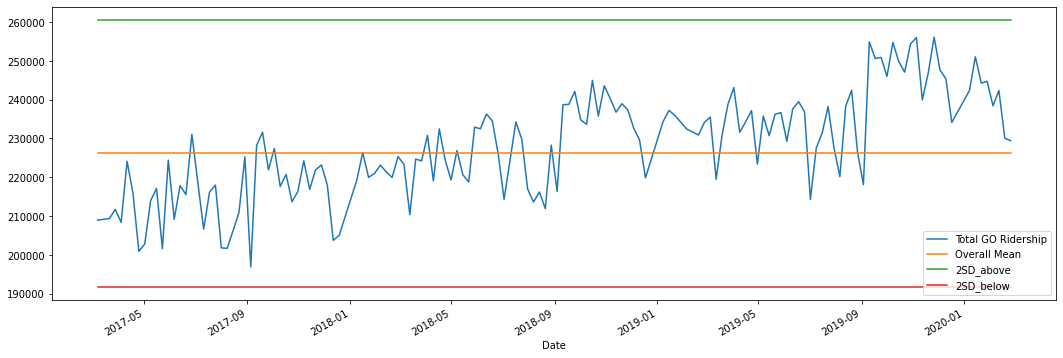

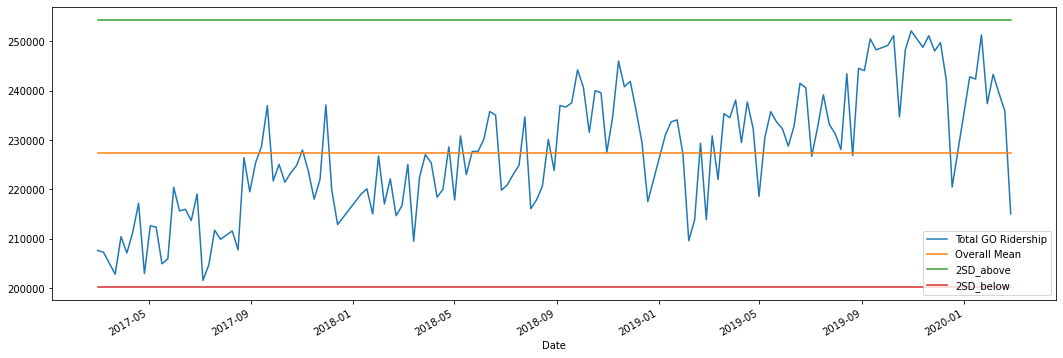

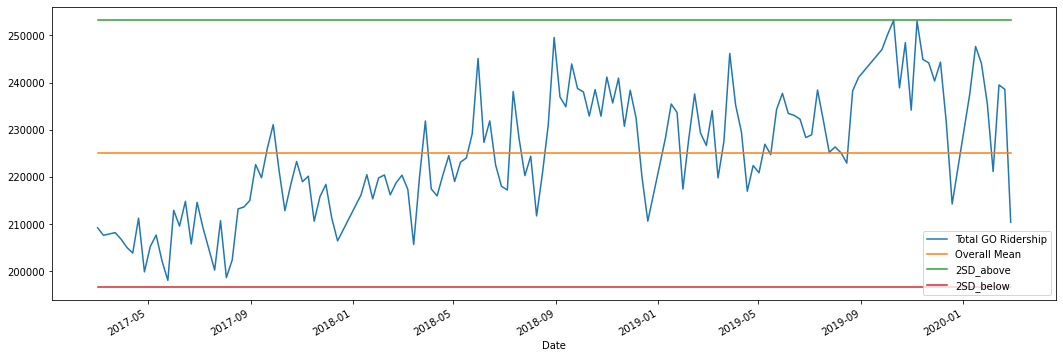

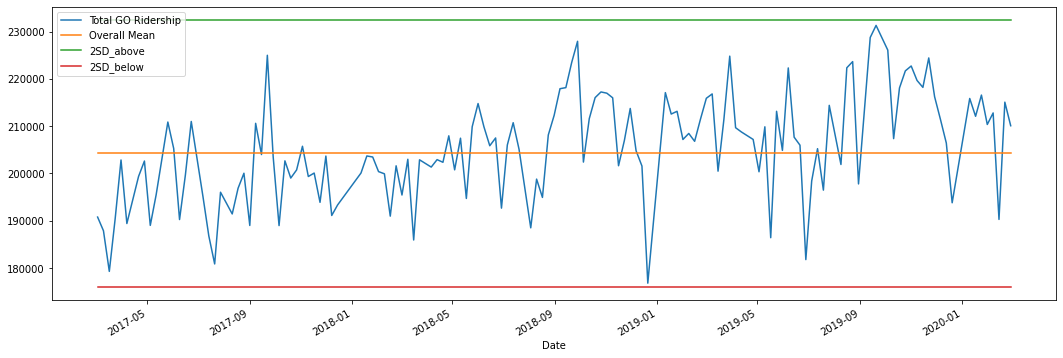

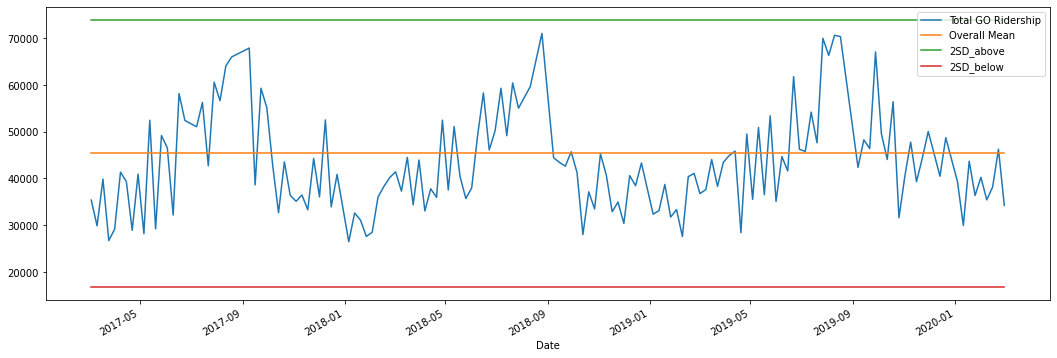

In [0]:
columns = ['Total GO Ridership', 'Overall Mean','2SD_above','2SD_below','Weekday','Holiday']
filter = (-transit_data.Holiday)&(-transit_data['Outlier'])
#df_new.groupby(by='Weekday').plot(figsize=(18,6))
transit_data.loc[filter,columns].groupby(by='Weekday').plot(figsize=(18,6))

In [0]:
transit_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2017-03-01 to 2020-02-29
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   Year                      1096 non-null   int64    
 1   Month                     1096 non-null   int64    
 2   year_month                1096 non-null   period[M]
 3   Day                       1096 non-null   int64    
 4   Weekday                   1096 non-null   category 
 5   Holiday                   1096 non-null   bool     
 6   Max Temp (°C)             1096 non-null   float64  
 7   Min Temp (°C)             1096 non-null   float64  
 8   Mean Temp (°C)            1096 non-null   float64  
 9   Monthly Mean Temp (°C)    1096 non-null   float64  
 10  Delta Temp (°C)           1096 non-null   float64  
 11  Total Precip (mm)         1096 non-null   float64  
 12  Monthly Mean Precip (mm)  1096 non-null   float64  
 13  Delta Precip (m

In [0]:
transit_data.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.10,-1.90,5.60,-0.25,5.85,18.40,2.34,16.06,0.00,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,"227,296.50","254,365.81","200,227.20"
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.30,-6.40,-3.90,-0.25,-3.65,0.20,2.34,-2.14,0.50,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,"224,966.62","253,295.70","196,637.54"
2017-03-03,2017,3,2017-03,3,Friday,False,-4.30,-8.10,-6.20,-0.25,-5.95,0.00,2.34,-2.34,0.50,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,"204,211.91","232,457.91","175,965.91"
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.50,-11.90,-9.20,-0.25,-8.95,0.20,2.34,-2.14,0.50,928,480,7872,11756,208,0,246,13899,35389,False,"45,352.33","73,886.66","16,818.01"
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.40,-10.60,-5.50,-0.25,-5.25,0.00,2.34,-2.34,0.50,803,398,4714,8381,169,0,156,8505,23126,False,"32,455.37","53,039.52","11,871.22"


## Visualize before and after exclusion of holidays and outliers

Comparison of the graphs below illustrates the desired data smoothing outcome from exclusion of unwanted values.

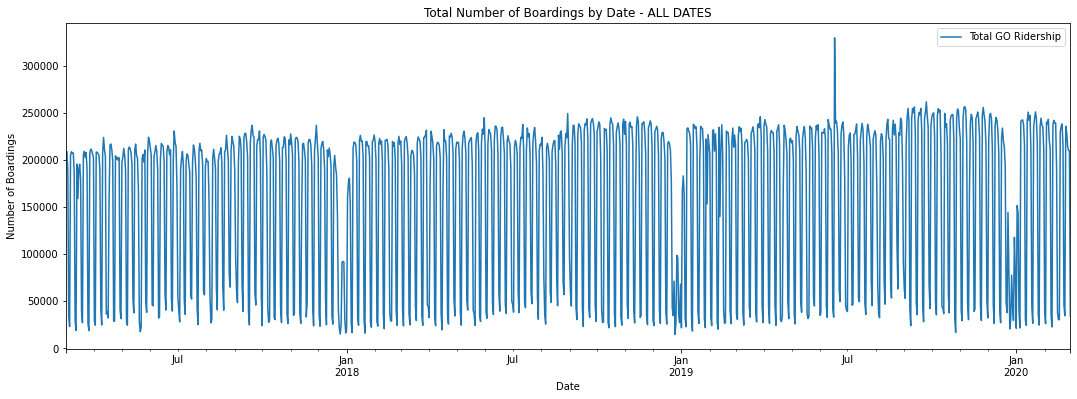

In [0]:
# Plot all data:
transit_data.plot(y='Total GO Ridership', figsize=(18,6))
plt.xlabel('Date')
plt.ylabel('Number of Boardings')
plt.title('Total Number of Boardings by Date - ALL DATES');

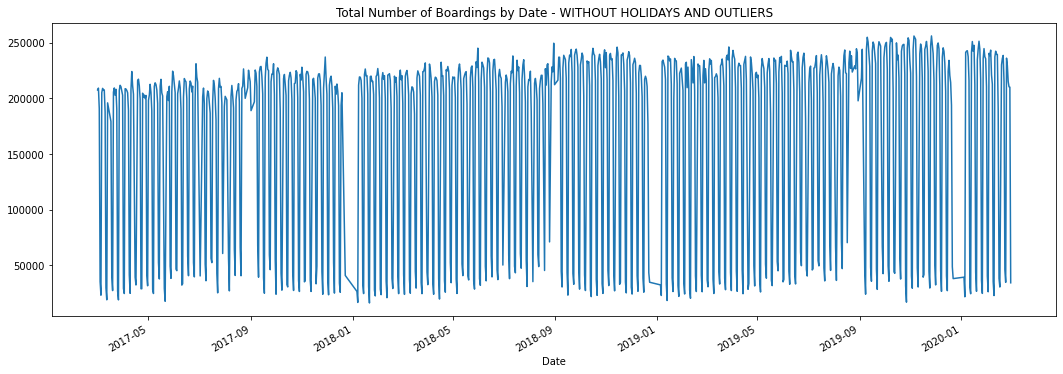

In [0]:
# Plot after removing holidays and outliers:
filter = (-transit_data.Holiday)&(-transit_data['Outlier'])
transit_data.loc[filter,'Total GO Ridership'].plot(y='Total GO Ridership', figsize=(18,6))
plt.title('Total Number of Boardings by Date - WITHOUT HOLIDAYS AND OUTLIERS');

## Write "Final Dataset.csv" File for Further Analysis

The new csv file will be used in:
* Analysis
 * Autocorrelation
 * Correlation
* Machine Learning
 * Classification
 * Regression

In [0]:
transit_data.to_csv("Final Dataset.csv")